# PART 1: MULTI LAYER NEURAL NETWORK

In [31]:

import pandas as pd
import os 
import cv2
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")


In [7]:

def load_and_preprocess_images(file_paths):
    images = []
    for file_path in file_paths:
        img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)  # Read image in grayscale
        img = cv2.resize(img, (32, 32))  # Resize image
        img = img / 255.0  # Normalize image values
        images.append(img)
    return np.array(images)

def one_hot_encode(y, num_classes):
    m = len(y)
    one_hot = np.zeros((num_classes, m))
    one_hot[y, np.arange(m)] = 1
    return one_hot

def initialize_parameters(input_size, hidden_sizes, output_size):
    np.random.seed(42)
    parameters = {}
    layer_sizes = [input_size] + hidden_sizes + [output_size]
    for i in range(1, len(layer_sizes)):
        parameters[f'W{i}'] = np.random.randn(layer_sizes[i], layer_sizes[i-1]) * np.sqrt(2 / layer_sizes[i-1])
        parameters[f'b{i}'] = np.zeros((layer_sizes[i], 1))
    return parameters

def sigmoid(Z, derivative=False):
    sig_Z = 1 / (1 + np.exp(-Z))
    if derivative: return sig_Z * (1 - sig_Z)
    else: return sig_Z

def relu(Z, derivative=False):
    if derivative: return np.where(Z > 0, 1, 0)
    else: return np.maximum(0, Z)

def softmax(Z):
    exp_Z = np.exp(Z - np.max(Z))  # for numerical stability
    return exp_Z / np.sum(exp_Z, axis=0, keepdims=True)

def forward_propagation(X, parameters , activation_func):
    caches = {'A0': X}
    A_prev = X
    for i in range(1, len(parameters) // 2 + 1):
        W = parameters[f'W{i}']
        b = parameters[f'b{i}']
        Z = np.dot(W, A_prev.T) + b
        A = activation_func(Z) if i < len(parameters) // 2 else softmax(Z)
        caches[f'Z{i}'] = Z
        caches[f'A{i}'] = A
        A_prev = A.T
    return caches, A

def compute_loss(Y, A_output):
    m = Y.shape[1]
    loss = -np.sum(Y * np.log(A_output+1e-7)) / m
    return loss

def backward_propagation(X, Y, parameters, caches, activation_func):
    m = X.shape[1]
    
    L = len(parameters) // 2
    grads = {}

    dA = caches[f'A{L}'] - Y 
    if L == 1:
        grads[f'dW{L}'] = np.dot(dA, caches[f'A{L-1}']) / m
    else:
        grads[f'dW{L}'] = np.dot(dA, caches[f'A{L-1}'].T) / m
    grads[f'db{L}'] = np.sum(dA, axis=1, keepdims=True) / m

    for l in reversed(range(1, L)):
        
        dZ = np.dot(parameters[f'W{l+1}'].T, dA)
        dA = dZ
        if activation_func == "sigmoid": dZ = dZ * caches[f'A{l}'] * (1 - caches[f'A{l}'])
        elif activation_func == "relu": dZ = dZ * relu(caches[f'A{l}'], derivative=True)
        if l == 1:    
            grads[f'dW{l}'] = np.dot(dZ, caches[f'A{l-1}']) / m
        else:
            grads[f'dW{l}'] = np.dot(dZ, caches[f'A{l-1}'].T) / m
        grads[f'db{l}'] = np.sum(dZ, axis=1, keepdims=True) / m

    return grads

def compute_gradients(X, Y, parameters,activation_func):
    caches, _ = forward_propagation(X, parameters,activation_func)
    grads = backward_propagation(X, Y, parameters, caches, activation_func)
    return grads

def numerical_gradients(X, Y, parameters, epsilon=1e-7):
    num_grads = {}
    for param_name, param_value in parameters.items():
        param_shape = param_value.shape
        param_value_plus_epsilon = param_value + epsilon
        param_value_minus_epsilon = param_value - epsilon
        loss_plus_epsilon = compute_loss(Y, forward_propagation(X, {param_name: param_value_plus_epsilon})[1])
        loss_minus_epsilon = compute_loss(Y, forward_propagation(X, {param_name: param_value_minus_epsilon})[1])
        num_grad = (loss_plus_epsilon - loss_minus_epsilon) / (2 * epsilon)
        num_grads[f'd{param_name}'] = num_grad.reshape(param_shape)
    return num_grads


def update_parameters(parameters, grads, learning_rate):
    L = len(parameters) // 2
    for l in range(1, L+1):
        parameters[f'W{l}'] -= learning_rate * grads[f'dW{l}']
        parameters[f'b{l}'] -= learning_rate * grads[f'db{l}']
    return parameters

def compute_accuracy(Y, A_output):
    predictions = np.argmax(A_output, axis=0)
    return np.mean(predictions == Y)


def mini_batch_gradient_descent(X, Y, X_test, y_test, input_size, hidden_sizes, output_size, learning_rate, epochs, batch_size, X_val, y_val, activation_func):
    
    parameters = initialize_parameters(input_size, hidden_sizes, output_size)
    

    training_history = {'loss': [], 'accuracy': []}
    validation_history = {'loss': [], 'accuracy': []}
    test_history = {'loss': [], 'accuracy': []}
    
    m = X.shape[0]

    act_func_str = ""
    if activation_func == sigmoid: act_func_str = "sigmoid"
    elif activation_func == relu: act_func_str = "relu"
    for epoch in range(1, epochs + 1):
        batch_history = {'train loss': [], 'validation loss': [], 'test loss': [],
                    'train acc': [], 'validation acc': [], 'test acc': []}
        for i in range(0, m, batch_size):
            X_batch = X[i:i+batch_size,:]
            Y_batch = Y[:,i:i+batch_size]

            caches, A_output_train = forward_propagation(X_batch, parameters, activation_func)
            grads = backward_propagation(X_batch, Y_batch, parameters, caches, act_func_str)
            train_loss = compute_loss(Y_batch, A_output_train)
            train_acc = compute_accuracy(Y_batch, A_output_train)
            batch_history['train loss'].append(train_loss)
            batch_history['train acc'].append(train_acc)

            _, A_output_val = forward_propagation(X_val, parameters, activation_func)
            val_loss = compute_loss(y_val, A_output_val)
            val_acc = compute_accuracy(y_val, A_output_val)
            batch_history['validation loss'].append(val_loss)
            batch_history['validation acc'].append(val_acc)

            _, A_output_test = forward_propagation(X_test, parameters, activation_func)
            test_loss = compute_loss(y_test, A_output_test)
            test_acc = compute_accuracy(y_test, A_output_test)
            batch_history['test loss'].append(test_loss)
            batch_history['test acc'].append(test_acc)
            
            parameters = update_parameters(parameters, grads, learning_rate)

        l_train = np.array(batch_history['train loss']).mean()
        a_train = np.array(batch_history['train acc']).mean()
        l_val = np.array(batch_history['validation loss']).mean()
        a_val = np.array(batch_history['validation acc']).mean()
        l_test = np.array(batch_history['test loss']).mean()
        a_test = np.array(batch_history['test acc']).mean()

        training_history['loss'].append(l_train)
        training_history['accuracy'].append(a_train)

        validation_history['loss'].append(l_val)
        validation_history['accuracy'].append(a_val)

        test_history['loss'].append(l_test)
        test_history['accuracy'].append(a_test)
        
        
        if epoch % 10 == 0:
            print(f'\nEpoch {epoch}/{epochs}:\nTrain Loss:\t{l_train:.4f}\tTrain Accuracy:\t{(a_train * 100):.2f}%\nVal. Loss:\t{l_val:.4f}\tVal. Accuracy:\t{(a_val * 100):.2f}%\nTest Loss:\t{l_test:.4f}\tTest Accuracy:\t{(a_test * 100):.2f}%')

    return parameters, training_history, validation_history, test_history

def visualize_learned_parameters(parameters, output_size):
    L = len(parameters) // 2
    fig, axes = plt.subplots(nrows=1, ncols=output_size, figsize=(output_size * 2 , output_size / 2))
    for i in range(output_size):
        weight_matrix = parameters[f'W{L}'][i, :]
        weight_matrix_reshaped = weight_matrix.reshape((parameters[f'W{L-1}'].shape[0], 1))
        
        axes[i].imshow(weight_matrix_reshaped, cmap='gray', aspect='auto')
        axes[i].set_title(f'Output Neuron {i}')
    plt.tight_layout()
    plt.show()

def mlp_experiments(X, Y, X_test, y_test, X_val, y_val):
    
    input_size = X.shape[1]
    output_size = 6
    epochs = 50

    num_experiments = 30

    hidden_sizes_list = [[], [], [], [], [], [],
                        [16], [16], [16], [16], [32], [32], [32], [32], [64], [64], [64], [64],
                        [32,16],[32,16],[32,16],[32,16],[64,32],[64,32],[64,32],[64,32],[128,64],[128,64],[128,64],[128,64]]
    
    learning_rates_list = [0.005,0.005,0.005,0.02,0.02,0.02,
                            0.005,0.005,0.02,0.02,0.005,0.005,0.02,0.02,0.005,0.005,0.02,0.02,
                            0.005,0.005,0.02,0.02,0.005,0.005,0.02,0.02,0.005,0.005,0.02,0.02]

    batch_sizes_list = [16,32,64,16,32,64,
                        16,32,16,32,16,32,16,32,16,32,16,32,
                        16,32,16,32,16,32,16,32,16,32,16,32]
    
    activation_functions_list = [relu, relu, relu, relu, relu, relu,
                                 sigmoid, relu, sigmoid, relu, sigmoid, relu, sigmoid, relu, sigmoid, relu,sigmoid, relu,
                                 sigmoid, relu, sigmoid, relu, sigmoid, relu, sigmoid, relu, sigmoid, relu,sigmoid, relu]
    
    act_funcs_str = ["sigmoid","relu","sigmoid","relu","sigmoid","relu","sigmoid","relu",
                    "sigmoid","relu","sigmoid","relu","sigmoid","relu","sigmoid","relu","sigmoid","relu","sigmoid","relu",
                    "sigmoid","relu","sigmoid","relu","sigmoid","relu","sigmoid","relu","sigmoid","relu""sigmoid","relu",]
    
    results = {"Experiments": [i+1 for i in range(num_experiments)],
                "Input Size": [f'{int(np.sqrt(input_size))}x{int(np.sqrt(input_size))}' for i in range(num_experiments)],
                "Activation": act_funcs_str,
                "Hidden Layer Size": hidden_sizes_list,
                "Learning Rate": learning_rates_list,
                "Batch Size": batch_sizes_list,
                "Epoch": [epochs for i in range(num_experiments)],
                "Accuracy": []}
    
    for i in range(num_experiments):
        print(f"\nEXPERIMENT for MLP: {i+1}\n-------------")
        print(f'Hidden Layer Sizes:{hidden_sizes_list[i]}, LR:{learning_rates_list[i]}, A:{act_funcs_str[i]}\n')
        _, training_history, validation_history, test_history = mini_batch_gradient_descent(X, Y, X_test, y_test, input_size, 
        hidden_sizes_list[i], output_size, learning_rates_list[i], epochs, batch_sizes_list[i], 
        X_val, y_val, activation_functions_list[i])
        accuracy = test_history['accuracy'][-1]
        results['Accuracy'].append(accuracy)

        fig, ax = plt.subplots(1,2, figsize=(15,5))
        
        ax[0].plot([i for i in range(epochs)], training_history['loss'], label="Training loss")
        ax[1].plot([i for i in range(epochs)], training_history['accuracy'], label="Training accuracy")
        ax[0].plot([i for i in range(epochs)], validation_history['loss'], label="Validation loss")
        ax[1].plot([i for i in range(epochs)], validation_history['accuracy'], label="Validation accuracy")
        ax[0].plot([i for i in range(epochs)], test_history['loss'], label="Test loss")
        ax[1].plot([i for i in range(epochs)], test_history['accuracy'], label="Test accuracy")
        ax[0].set_title(f"Hidden Layer Sizes:{hidden_sizes_list[i]}, LR:{learning_rates_list[i]}, A:{act_funcs_str[i]}")
        ax[1].set_title(f"Hidden Layer Sizes:{hidden_sizes_list[i]}, LR:{learning_rates_list[i]}, A:{act_funcs_str[i]}")
        ax[0].set_xlabel("Epoch")
        ax[0].set_ylabel("Loss")
        ax[1].set_xlabel("Epoch")
        ax[1].set_ylabel("Accuracy")
        ax[0].legend()
        ax[1].legend()
        plt.show()
        
    return results



In [15]:
from sklearn.preprocessing import OneHotEncoder


train_data = pd.read_csv("dataset_a3/voice_dataset/train_data.csv")
test_data = pd.read_csv("dataset_a3/voice_dataset/test_data.csv")

train_image_path = "dataset_a3/voice_dataset/train/"
test_image_path = "dataset_a3/voice_dataset/test/"

train_data['full_path'] = [os.path.join(train_image_path, filename) for filename in train_data['filename']] 
test_data['full_path'] = [os.path.join(test_image_path, filename) for filename in test_data['filename']]

train_images = load_and_preprocess_images(train_data['full_path'])
test_images = load_and_preprocess_images(test_data['full_path'])

train_data = train_data.replace(to_replace = ['teens','twenties', 'thirties', 'fourties', 'fifties', 'sixties'], value = [0,1, 2, 3, 4, 5])
test_data = test_data.replace(to_replace = ['teens','twenties', 'thirties', 'fourties', 'fifties', 'sixties'], value = [0,1, 2, 3, 4, 5])

X = train_images
y = np.array(train_data['age'])

X_test = test_images
y_test = np.array(test_data['age'])

X_train_images, X_val_images, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_flatten = X_train_images.reshape(X_train_images.shape[0], -1)
X_val_flatten = X_val_images.reshape(X_val_images.shape[0], -1)
X_test_flatten = X_test.reshape(X_test.shape[0], -1)

train_y = OneHotEncoder().fit_transform(y_train.reshape(-1, 1)).toarray()
val_y = OneHotEncoder().fit_transform(y_val.reshape(-1, 1)).toarray()
test_y = OneHotEncoder().fit_transform(y_test.reshape(-1, 1)).toarray()

y_train = one_hot_encode(y_train, 6)
y_val = one_hot_encode(y_val, 6)
y_test = one_hot_encode(y_test, 6)

In [7]:
np.random.seed(42)
input_size = X_train_flatten.shape[1]
hidden_sizes = [64,32]
output_size = 6
learning_rate = 0.01
batch_size = 64
epochs = 50
activation_func = relu



Epoch 10/50:
Train Loss:	1.7929	Train Accuracy:	7.23%
Val. Loss:	1.7934	Val. Accuracy:	6.70%
Test Loss:	1.7965	Test Accuracy:	7.61%

Epoch 20/50:
Train Loss:	1.7868	Train Accuracy:	17.91%
Val. Loss:	1.7868	Val. Accuracy:	16.55%
Test Loss:	1.7904	Test Accuracy:	18.39%

Epoch 30/50:
Train Loss:	1.7819	Train Accuracy:	20.91%
Val. Loss:	1.7811	Val. Accuracy:	19.93%
Test Loss:	1.7856	Test Accuracy:	21.25%

Epoch 40/50:
Train Loss:	1.7774	Train Accuracy:	20.90%
Val. Loss:	1.7764	Val. Accuracy:	19.99%
Test Loss:	1.7811	Test Accuracy:	21.06%

Epoch 50/50:
Train Loss:	1.7731	Train Accuracy:	20.47%
Val. Loss:	1.7719	Val. Accuracy:	19.76%
Test Loss:	1.7772	Test Accuracy:	20.82%


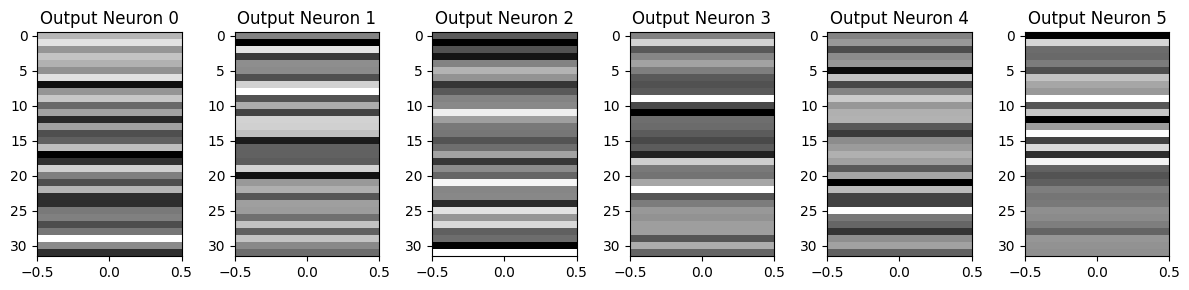

In [8]:
trained_parameters, training_history, validation_history, test_history = mini_batch_gradient_descent(X_train_flatten, y_train, X_test_flatten, y_test, input_size, hidden_sizes, output_size, learning_rate, epochs, batch_size, X_val_flatten, y_val, activation_func)

visualize_learned_parameters(trained_parameters, output_size)


EXPERIMENT for MLP: 1
-------------
Hidden Layer Sizes:[], LR:0.005, A:sigmoid


Epoch 10/50:
Train Loss:	1.8045	Train Accuracy:	21.56%
Val. Loss:	1.8033	Val. Accuracy:	21.28%
Test Loss:	1.8049	Test Accuracy:	21.30%

Epoch 20/50:
Train Loss:	1.8002	Train Accuracy:	21.72%
Val. Loss:	1.7989	Val. Accuracy:	21.72%
Test Loss:	1.8008	Test Accuracy:	21.23%

Epoch 30/50:
Train Loss:	1.7963	Train Accuracy:	22.22%
Val. Loss:	1.7950	Val. Accuracy:	22.56%
Test Loss:	1.7971	Test Accuracy:	21.75%

Epoch 40/50:
Train Loss:	1.7927	Train Accuracy:	22.76%
Val. Loss:	1.7914	Val. Accuracy:	23.35%
Test Loss:	1.7938	Test Accuracy:	22.30%

Epoch 50/50:
Train Loss:	1.7895	Train Accuracy:	23.54%
Val. Loss:	1.7881	Val. Accuracy:	24.52%
Test Loss:	1.7908	Test Accuracy:	23.27%


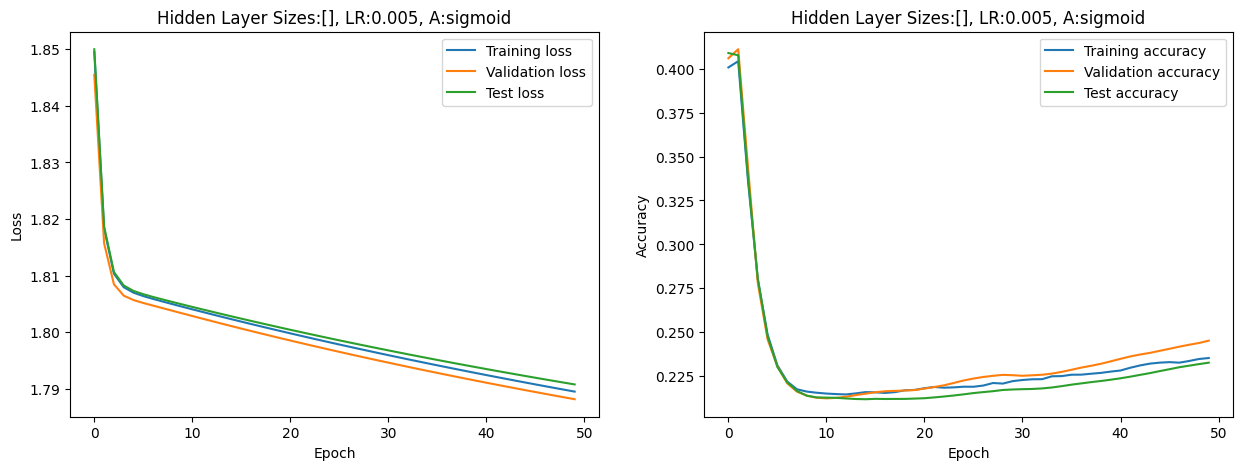


EXPERIMENT for MLP: 2
-------------
Hidden Layer Sizes:[], LR:0.005, A:relu


Epoch 10/50:
Train Loss:	1.8045	Train Accuracy:	21.57%
Val. Loss:	1.8033	Val. Accuracy:	21.28%
Test Loss:	1.8049	Test Accuracy:	21.29%

Epoch 20/50:
Train Loss:	1.8002	Train Accuracy:	21.73%
Val. Loss:	1.7989	Val. Accuracy:	21.72%
Test Loss:	1.8008	Test Accuracy:	21.23%

Epoch 30/50:
Train Loss:	1.7963	Train Accuracy:	22.25%
Val. Loss:	1.7950	Val. Accuracy:	22.56%
Test Loss:	1.7971	Test Accuracy:	21.75%

Epoch 40/50:
Train Loss:	1.7927	Train Accuracy:	22.74%
Val. Loss:	1.7914	Val. Accuracy:	23.35%
Test Loss:	1.7938	Test Accuracy:	22.30%

Epoch 50/50:
Train Loss:	1.7895	Train Accuracy:	23.51%
Val. Loss:	1.7881	Val. Accuracy:	24.52%
Test Loss:	1.7908	Test Accuracy:	23.27%


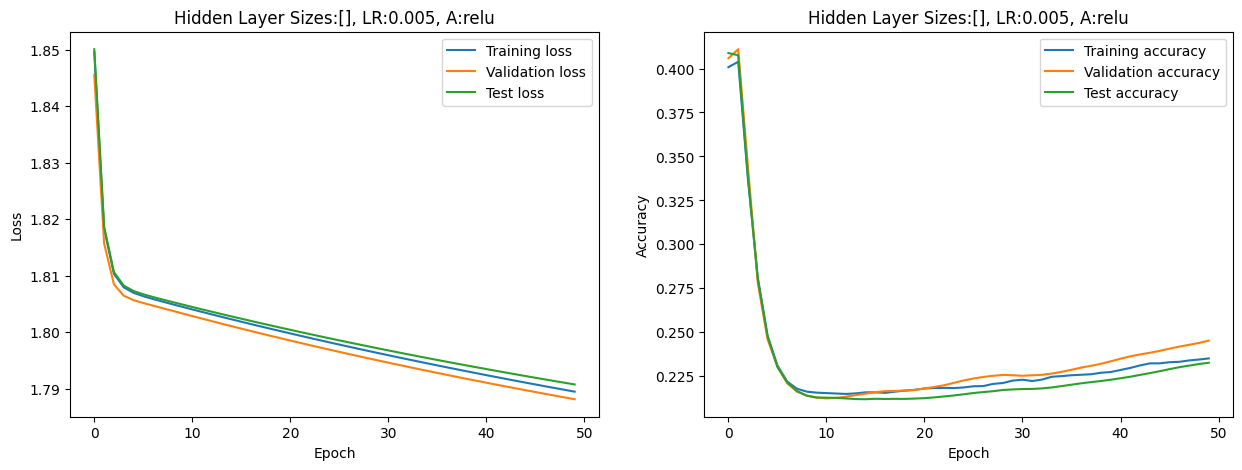


EXPERIMENT for MLP: 3
-------------
Hidden Layer Sizes:[], LR:0.005, A:sigmoid


Epoch 10/50:
Train Loss:	1.8045	Train Accuracy:	21.57%
Val. Loss:	1.8033	Val. Accuracy:	21.28%
Test Loss:	1.8049	Test Accuracy:	21.29%

Epoch 20/50:
Train Loss:	1.8002	Train Accuracy:	21.72%
Val. Loss:	1.7989	Val. Accuracy:	21.72%
Test Loss:	1.8008	Test Accuracy:	21.22%

Epoch 30/50:
Train Loss:	1.7963	Train Accuracy:	22.25%
Val. Loss:	1.7950	Val. Accuracy:	22.55%
Test Loss:	1.7971	Test Accuracy:	21.75%

Epoch 40/50:
Train Loss:	1.7928	Train Accuracy:	22.78%
Val. Loss:	1.7914	Val. Accuracy:	23.35%
Test Loss:	1.7938	Test Accuracy:	22.30%

Epoch 50/50:
Train Loss:	1.7895	Train Accuracy:	23.51%
Val. Loss:	1.7881	Val. Accuracy:	24.53%
Test Loss:	1.7908	Test Accuracy:	23.27%


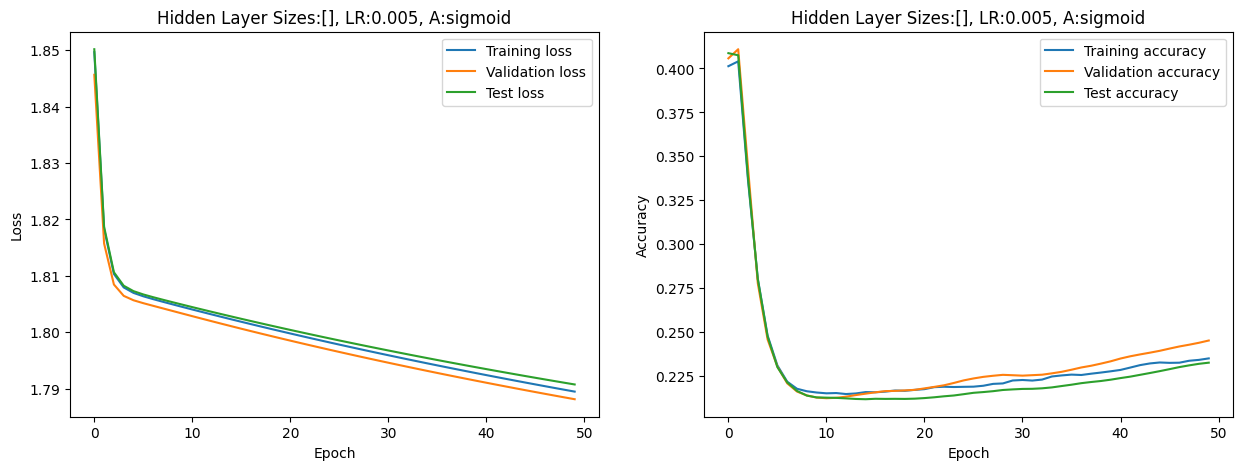


EXPERIMENT for MLP: 4
-------------
Hidden Layer Sizes:[], LR:0.02, A:relu


Epoch 10/50:
Train Loss:	1.7938	Train Accuracy:	22.95%
Val. Loss:	1.7921	Val. Accuracy:	23.14%
Test Loss:	1.7944	Test Accuracy:	22.24%

Epoch 20/50:
Train Loss:	1.7821	Train Accuracy:	25.23%
Val. Loss:	1.7804	Val. Accuracy:	26.88%
Test Loss:	1.7836	Test Accuracy:	24.80%

Epoch 30/50:
Train Loss:	1.7731	Train Accuracy:	26.59%
Val. Loss:	1.7719	Val. Accuracy:	28.43%
Test Loss:	1.7756	Test Accuracy:	26.16%

Epoch 40/50:
Train Loss:	1.7658	Train Accuracy:	27.56%
Val. Loss:	1.7652	Val. Accuracy:	29.08%
Test Loss:	1.7693	Test Accuracy:	27.09%

Epoch 50/50:
Train Loss:	1.7596	Train Accuracy:	27.77%
Val. Loss:	1.7597	Val. Accuracy:	29.26%
Test Loss:	1.7641	Test Accuracy:	27.63%


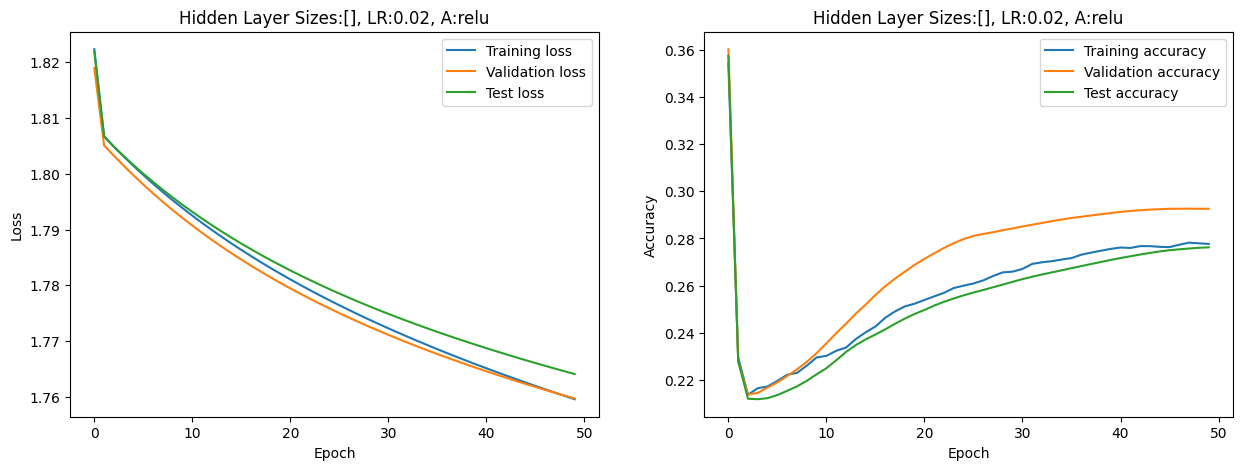


EXPERIMENT for MLP: 5
-------------
Hidden Layer Sizes:[], LR:0.02, A:sigmoid


Epoch 10/50:
Train Loss:	1.7938	Train Accuracy:	22.88%
Val. Loss:	1.7921	Val. Accuracy:	23.14%
Test Loss:	1.7944	Test Accuracy:	22.23%

Epoch 20/50:
Train Loss:	1.7820	Train Accuracy:	25.30%
Val. Loss:	1.7804	Val. Accuracy:	26.88%
Test Loss:	1.7836	Test Accuracy:	24.79%

Epoch 30/50:
Train Loss:	1.7731	Train Accuracy:	26.60%
Val. Loss:	1.7719	Val. Accuracy:	28.43%
Test Loss:	1.7756	Test Accuracy:	26.17%

Epoch 40/50:
Train Loss:	1.7658	Train Accuracy:	27.62%
Val. Loss:	1.7652	Val. Accuracy:	29.09%
Test Loss:	1.7693	Test Accuracy:	27.09%

Epoch 50/50:
Train Loss:	1.7596	Train Accuracy:	27.78%
Val. Loss:	1.7597	Val. Accuracy:	29.26%
Test Loss:	1.7641	Test Accuracy:	27.62%


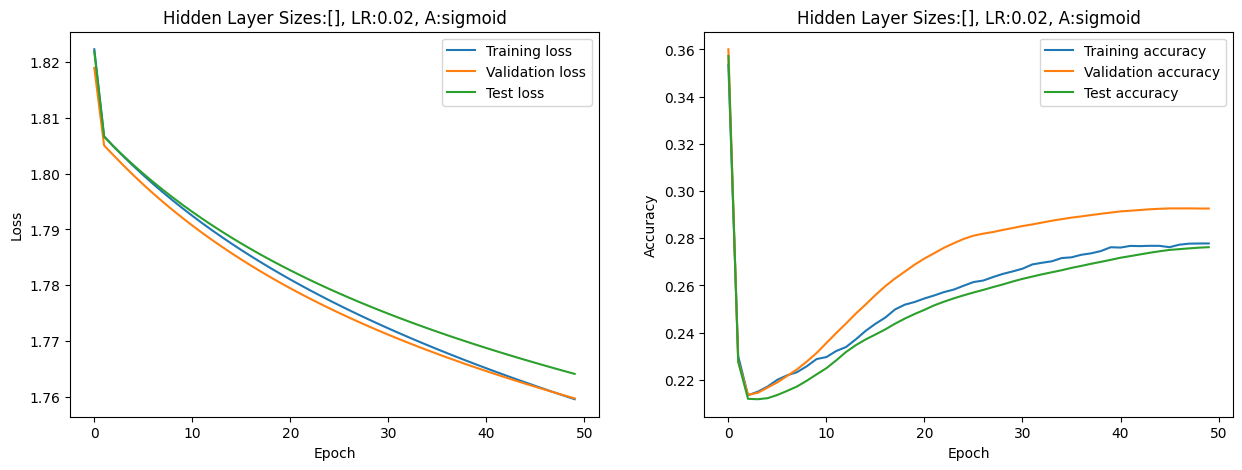


EXPERIMENT for MLP: 6
-------------
Hidden Layer Sizes:[], LR:0.02, A:relu


Epoch 10/50:
Train Loss:	1.7939	Train Accuracy:	23.00%
Val. Loss:	1.7921	Val. Accuracy:	23.12%
Test Loss:	1.7944	Test Accuracy:	22.24%

Epoch 20/50:
Train Loss:	1.7821	Train Accuracy:	25.26%
Val. Loss:	1.7804	Val. Accuracy:	26.86%
Test Loss:	1.7836	Test Accuracy:	24.81%

Epoch 30/50:
Train Loss:	1.7731	Train Accuracy:	26.65%
Val. Loss:	1.7719	Val. Accuracy:	28.44%
Test Loss:	1.7756	Test Accuracy:	26.18%

Epoch 40/50:
Train Loss:	1.7658	Train Accuracy:	27.52%
Val. Loss:	1.7652	Val. Accuracy:	29.10%
Test Loss:	1.7693	Test Accuracy:	27.10%

Epoch 50/50:
Train Loss:	1.7596	Train Accuracy:	27.83%
Val. Loss:	1.7597	Val. Accuracy:	29.27%
Test Loss:	1.7641	Test Accuracy:	27.63%


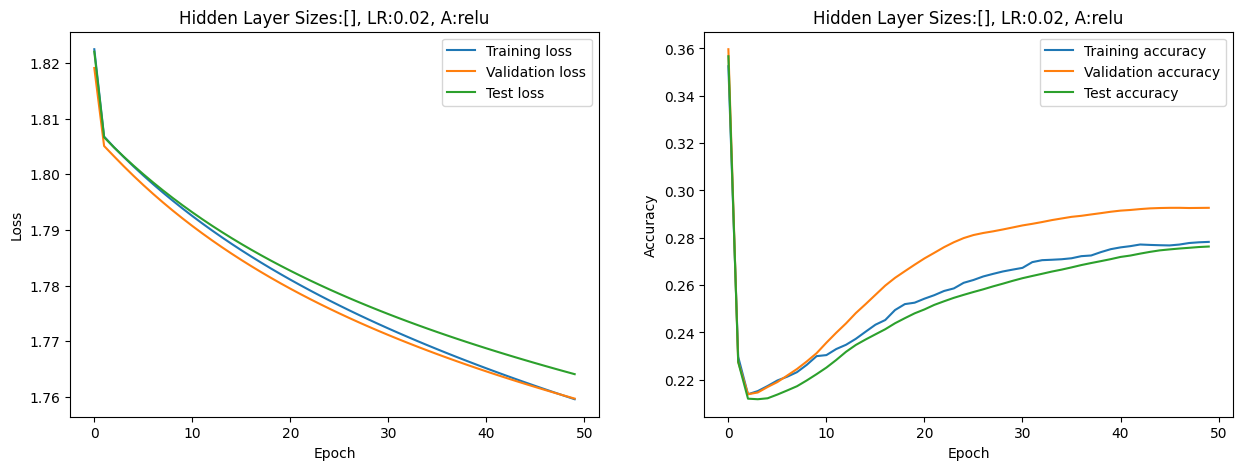


EXPERIMENT for MLP: 7
-------------
Hidden Layer Sizes:[16], LR:0.005, A:sigmoid


Epoch 10/50:
Train Loss:	1.8366	Train Accuracy:	1.38%
Val. Loss:	1.8343	Val. Accuracy:	1.44%
Test Loss:	1.8359	Test Accuracy:	1.57%

Epoch 20/50:
Train Loss:	1.7969	Train Accuracy:	6.11%
Val. Loss:	1.7962	Val. Accuracy:	5.91%
Test Loss:	1.7969	Test Accuracy:	6.30%

Epoch 30/50:
Train Loss:	1.7897	Train Accuracy:	7.01%
Val. Loss:	1.7896	Val. Accuracy:	6.73%
Test Loss:	1.7900	Test Accuracy:	7.17%

Epoch 40/50:
Train Loss:	1.7876	Train Accuracy:	7.29%
Val. Loss:	1.7877	Val. Accuracy:	6.91%
Test Loss:	1.7880	Test Accuracy:	7.37%

Epoch 50/50:
Train Loss:	1.7866	Train Accuracy:	8.89%
Val. Loss:	1.7869	Val. Accuracy:	8.44%
Test Loss:	1.7871	Test Accuracy:	8.74%


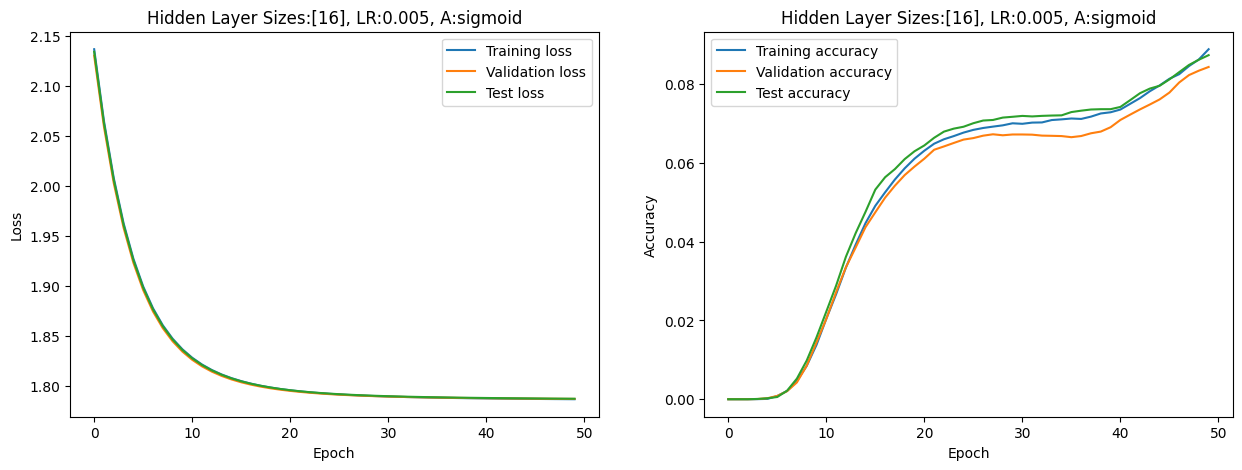


EXPERIMENT for MLP: 8
-------------
Hidden Layer Sizes:[16], LR:0.005, A:relu


Epoch 10/50:
Train Loss:	1.7908	Train Accuracy:	20.66%
Val. Loss:	1.7935	Val. Accuracy:	21.71%
Test Loss:	1.7923	Test Accuracy:	19.91%

Epoch 20/50:
Train Loss:	1.7895	Train Accuracy:	27.58%
Val. Loss:	1.7922	Val. Accuracy:	28.65%
Test Loss:	1.7902	Test Accuracy:	26.75%

Epoch 30/50:
Train Loss:	1.7884	Train Accuracy:	33.27%
Val. Loss:	1.7916	Val. Accuracy:	33.87%
Test Loss:	1.7889	Test Accuracy:	32.78%

Epoch 40/50:
Train Loss:	1.7874	Train Accuracy:	35.76%
Val. Loss:	1.7911	Val. Accuracy:	35.95%
Test Loss:	1.7880	Test Accuracy:	36.06%

Epoch 50/50:
Train Loss:	1.7866	Train Accuracy:	37.19%
Val. Loss:	1.7906	Val. Accuracy:	36.81%
Test Loss:	1.7874	Test Accuracy:	37.49%


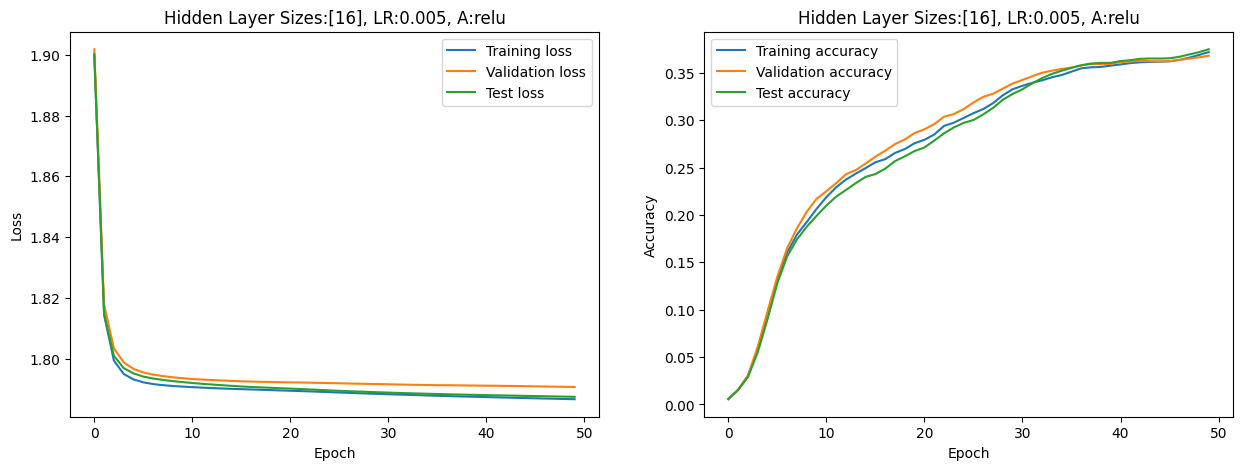


EXPERIMENT for MLP: 9
-------------
Hidden Layer Sizes:[16], LR:0.02, A:sigmoid


Epoch 10/50:
Train Loss:	1.7878	Train Accuracy:	7.18%
Val. Loss:	1.7879	Val. Accuracy:	6.85%
Test Loss:	1.7882	Test Accuracy:	7.35%

Epoch 20/50:
Train Loss:	1.7853	Train Accuracy:	13.80%
Val. Loss:	1.7856	Val. Accuracy:	13.38%
Test Loss:	1.7858	Test Accuracy:	14.01%

Epoch 30/50:
Train Loss:	1.7837	Train Accuracy:	16.17%
Val. Loss:	1.7840	Val. Accuracy:	16.51%
Test Loss:	1.7843	Test Accuracy:	16.17%

Epoch 40/50:
Train Loss:	1.7822	Train Accuracy:	17.09%
Val. Loss:	1.7825	Val. Accuracy:	17.84%
Test Loss:	1.7828	Test Accuracy:	17.49%

Epoch 50/50:
Train Loss:	1.7808	Train Accuracy:	17.83%
Val. Loss:	1.7811	Val. Accuracy:	18.65%
Test Loss:	1.7815	Test Accuracy:	18.48%


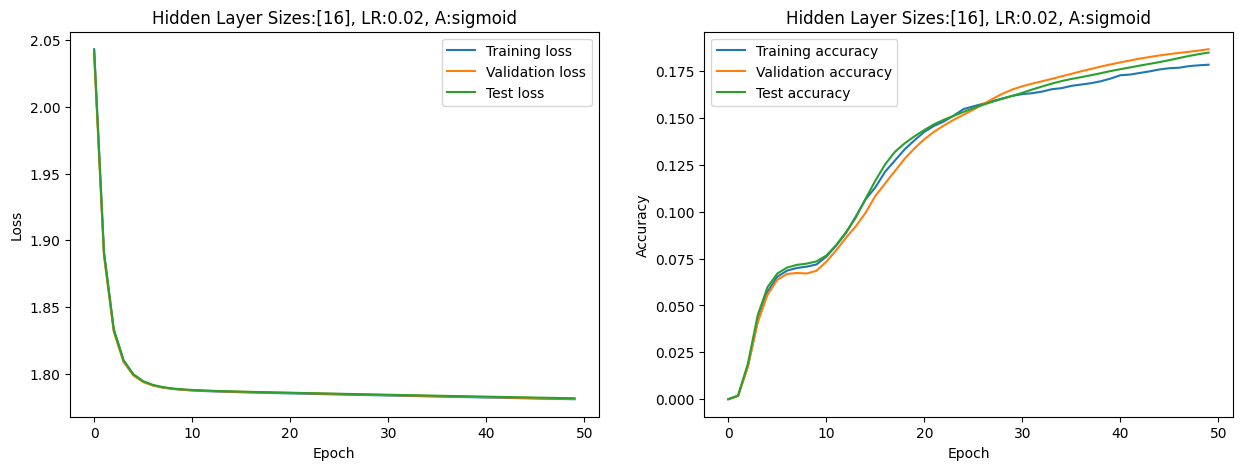


EXPERIMENT for MLP: 10
-------------
Hidden Layer Sizes:[16], LR:0.02, A:relu


Epoch 10/50:
Train Loss:	1.7877	Train Accuracy:	35.31%
Val. Loss:	1.7911	Val. Accuracy:	35.96%
Test Loss:	1.7879	Test Accuracy:	35.41%

Epoch 20/50:
Train Loss:	1.7848	Train Accuracy:	37.40%
Val. Loss:	1.7889	Val. Accuracy:	37.70%
Test Loss:	1.7853	Test Accuracy:	37.93%

Epoch 30/50:
Train Loss:	1.7818	Train Accuracy:	34.00%
Val. Loss:	1.7860	Val. Accuracy:	34.55%
Test Loss:	1.7829	Test Accuracy:	34.80%

Epoch 40/50:
Train Loss:	1.7786	Train Accuracy:	33.85%
Val. Loss:	1.7827	Val. Accuracy:	34.71%
Test Loss:	1.7800	Test Accuracy:	34.78%

Epoch 50/50:
Train Loss:	1.7753	Train Accuracy:	32.51%
Val. Loss:	1.7791	Val. Accuracy:	32.82%
Test Loss:	1.7770	Test Accuracy:	32.89%


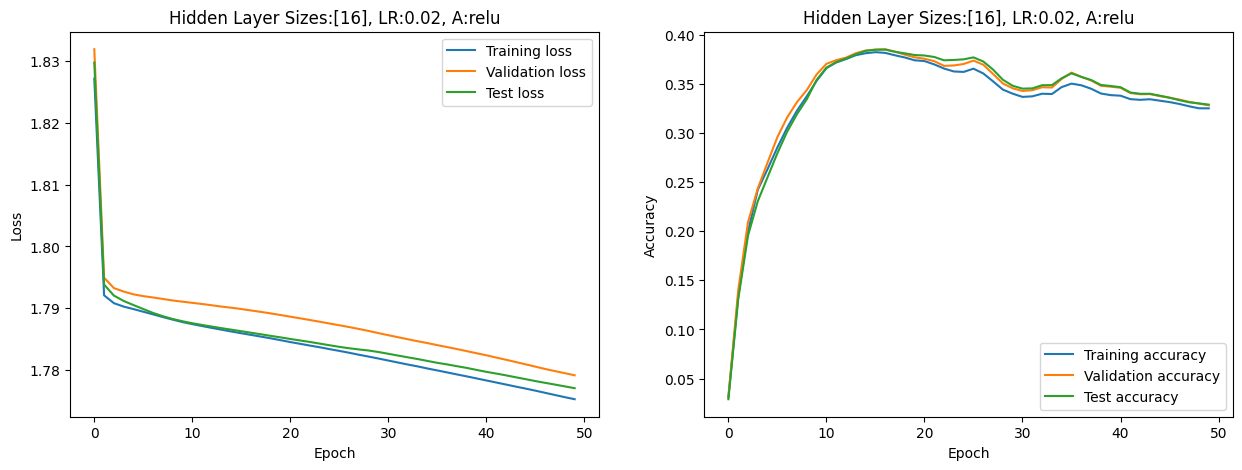


EXPERIMENT for MLP: 11
-------------
Hidden Layer Sizes:[32], LR:0.005, A:sigmoid


Epoch 10/50:
Train Loss:	1.8271	Train Accuracy:	9.21%
Val. Loss:	1.8328	Val. Accuracy:	9.05%
Test Loss:	1.8274	Test Accuracy:	8.89%

Epoch 20/50:
Train Loss:	1.7944	Train Accuracy:	7.58%
Val. Loss:	1.7978	Val. Accuracy:	7.31%
Test Loss:	1.7942	Test Accuracy:	7.28%

Epoch 30/50:
Train Loss:	1.7897	Train Accuracy:	14.61%
Val. Loss:	1.7921	Val. Accuracy:	13.70%
Test Loss:	1.7893	Test Accuracy:	14.30%

Epoch 40/50:
Train Loss:	1.7885	Train Accuracy:	24.66%
Val. Loss:	1.7905	Val. Accuracy:	24.25%
Test Loss:	1.7881	Test Accuracy:	23.06%

Epoch 50/50:
Train Loss:	1.7877	Train Accuracy:	28.39%
Val. Loss:	1.7896	Val. Accuracy:	28.45%
Test Loss:	1.7873	Test Accuracy:	27.17%


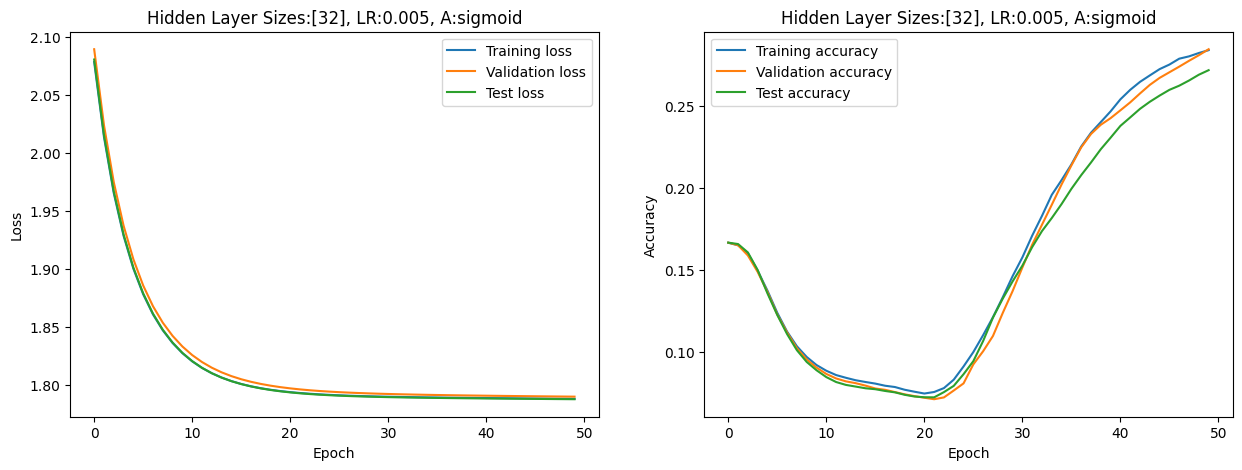


EXPERIMENT for MLP: 12
-------------
Hidden Layer Sizes:[32], LR:0.005, A:relu


Epoch 10/50:
Train Loss:	1.7937	Train Accuracy:	34.59%
Val. Loss:	1.7953	Val. Accuracy:	34.60%
Test Loss:	1.7958	Test Accuracy:	34.42%

Epoch 20/50:
Train Loss:	1.7895	Train Accuracy:	34.57%
Val. Loss:	1.7915	Val. Accuracy:	34.29%
Test Loss:	1.7926	Test Accuracy:	34.61%

Epoch 30/50:
Train Loss:	1.7863	Train Accuracy:	33.76%
Val. Loss:	1.7881	Val. Accuracy:	33.66%
Test Loss:	1.7903	Test Accuracy:	33.28%

Epoch 40/50:
Train Loss:	1.7836	Train Accuracy:	32.72%
Val. Loss:	1.7855	Val. Accuracy:	32.69%
Test Loss:	1.7885	Test Accuracy:	31.81%

Epoch 50/50:
Train Loss:	1.7813	Train Accuracy:	31.89%
Val. Loss:	1.7830	Val. Accuracy:	31.97%
Test Loss:	1.7866	Test Accuracy:	31.04%


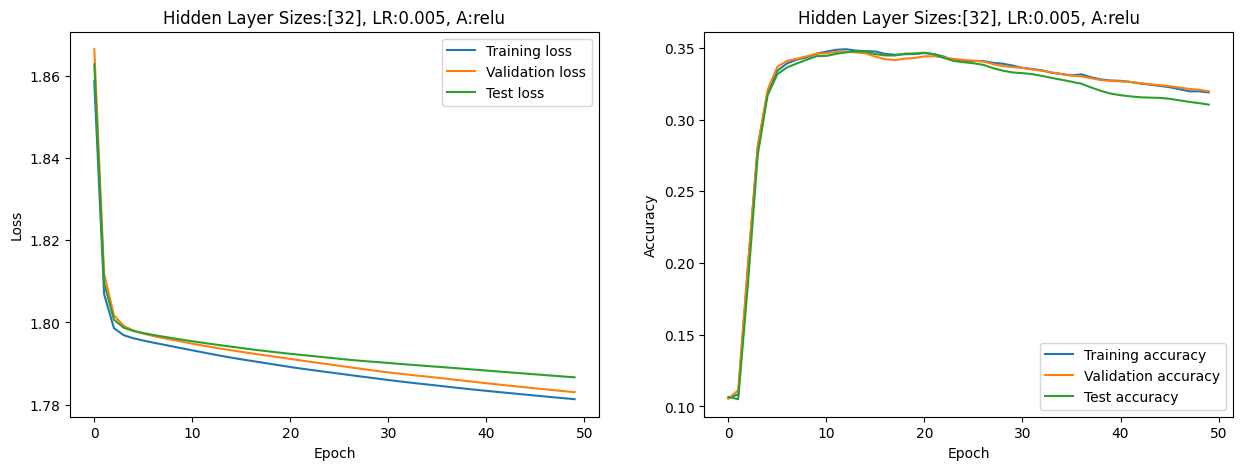


EXPERIMENT for MLP: 13
-------------
Hidden Layer Sizes:[32], LR:0.02, A:sigmoid


Epoch 10/50:
Train Loss:	1.7887	Train Accuracy:	23.52%
Val. Loss:	1.7907	Val. Accuracy:	23.35%
Test Loss:	1.7882	Test Accuracy:	21.98%

Epoch 20/50:
Train Loss:	1.7859	Train Accuracy:	31.23%
Val. Loss:	1.7875	Val. Accuracy:	31.55%
Test Loss:	1.7856	Test Accuracy:	29.89%

Epoch 30/50:
Train Loss:	1.7834	Train Accuracy:	31.81%
Val. Loss:	1.7850	Val. Accuracy:	32.40%
Test Loss:	1.7833	Test Accuracy:	30.71%

Epoch 40/50:
Train Loss:	1.7810	Train Accuracy:	31.96%
Val. Loss:	1.7826	Val. Accuracy:	32.71%
Test Loss:	1.7812	Test Accuracy:	31.11%

Epoch 50/50:
Train Loss:	1.7788	Train Accuracy:	31.97%
Val. Loss:	1.7803	Val. Accuracy:	33.01%
Test Loss:	1.7792	Test Accuracy:	31.50%


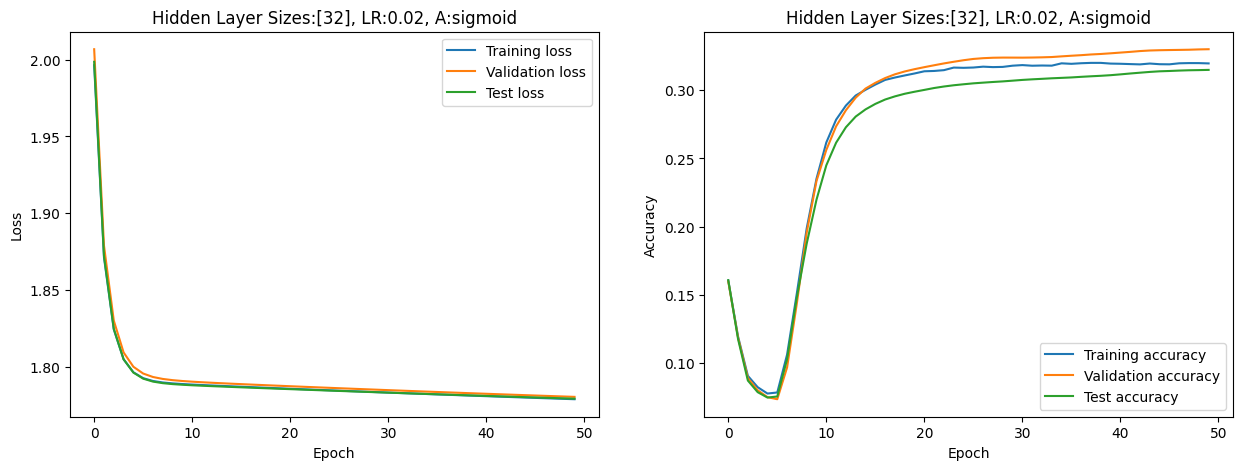


EXPERIMENT for MLP: 14
-------------
Hidden Layer Sizes:[32], LR:0.02, A:relu


Epoch 10/50:
Train Loss:	1.7843	Train Accuracy:	32.68%
Val. Loss:	1.7859	Val. Accuracy:	32.69%
Test Loss:	1.7890	Test Accuracy:	31.92%

Epoch 20/50:
Train Loss:	1.7762	Train Accuracy:	30.88%
Val. Loss:	1.7776	Val. Accuracy:	31.34%
Test Loss:	1.7822	Test Accuracy:	30.02%

Epoch 30/50:
Train Loss:	1.7696	Train Accuracy:	30.46%
Val. Loss:	1.7710	Val. Accuracy:	31.22%
Test Loss:	1.7765	Test Accuracy:	29.54%

Epoch 40/50:
Train Loss:	1.7637	Train Accuracy:	30.00%
Val. Loss:	1.7652	Val. Accuracy:	30.89%
Test Loss:	1.7716	Test Accuracy:	29.21%

Epoch 50/50:
Train Loss:	1.7583	Train Accuracy:	29.54%
Val. Loss:	1.7600	Val. Accuracy:	30.41%
Test Loss:	1.7670	Test Accuracy:	28.87%


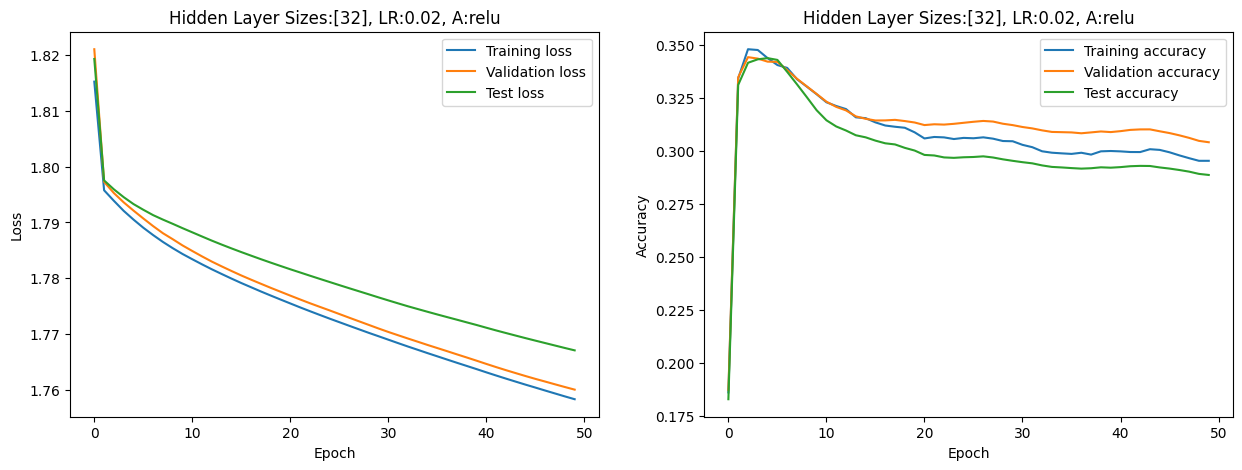


EXPERIMENT for MLP: 15
-------------
Hidden Layer Sizes:[64], LR:0.005, A:sigmoid


Epoch 10/50:
Train Loss:	1.7983	Train Accuracy:	7.00%
Val. Loss:	1.8024	Val. Accuracy:	7.35%
Test Loss:	1.7996	Test Accuracy:	6.88%

Epoch 20/50:
Train Loss:	1.7889	Train Accuracy:	14.86%
Val. Loss:	1.7908	Val. Accuracy:	15.21%
Test Loss:	1.7897	Test Accuracy:	14.78%

Epoch 30/50:
Train Loss:	1.7879	Train Accuracy:	26.97%
Val. Loss:	1.7895	Val. Accuracy:	27.34%
Test Loss:	1.7887	Test Accuracy:	26.38%

Epoch 40/50:
Train Loss:	1.7872	Train Accuracy:	29.33%
Val. Loss:	1.7887	Val. Accuracy:	30.35%
Test Loss:	1.7881	Test Accuracy:	29.13%

Epoch 50/50:
Train Loss:	1.7866	Train Accuracy:	29.98%
Val. Loss:	1.7881	Val. Accuracy:	30.94%
Test Loss:	1.7875	Test Accuracy:	29.75%


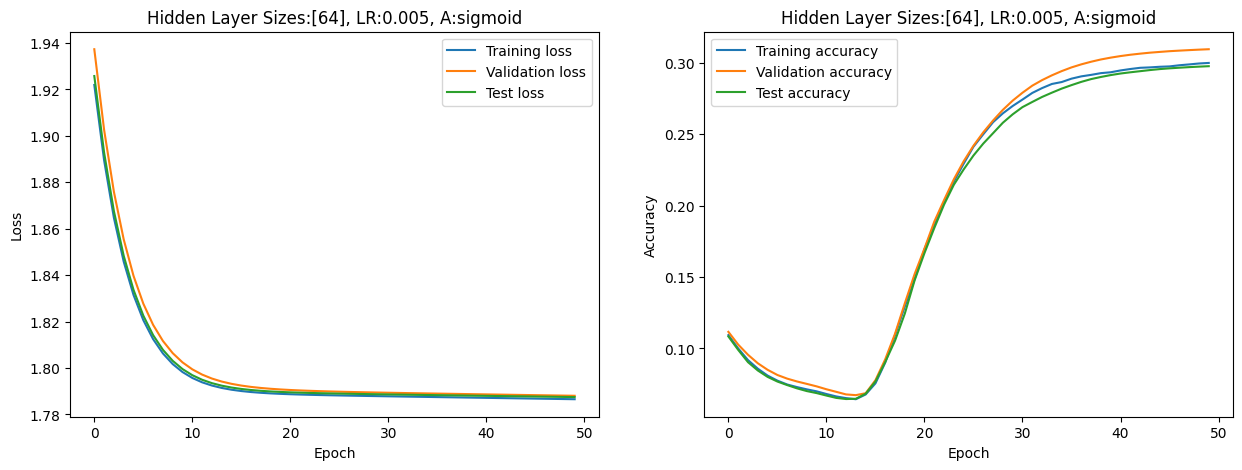


EXPERIMENT for MLP: 16
-------------
Hidden Layer Sizes:[64], LR:0.005, A:relu


Epoch 10/50:
Train Loss:	1.7937	Train Accuracy:	20.81%
Val. Loss:	1.7936	Val. Accuracy:	19.49%
Test Loss:	1.7962	Test Accuracy:	20.83%

Epoch 20/50:
Train Loss:	1.7895	Train Accuracy:	21.96%
Val. Loss:	1.7895	Val. Accuracy:	20.68%
Test Loss:	1.7925	Test Accuracy:	21.64%

Epoch 30/50:
Train Loss:	1.7856	Train Accuracy:	21.67%
Val. Loss:	1.7859	Val. Accuracy:	20.76%
Test Loss:	1.7891	Test Accuracy:	21.25%

Epoch 40/50:
Train Loss:	1.7820	Train Accuracy:	22.17%
Val. Loss:	1.7827	Val. Accuracy:	21.23%
Test Loss:	1.7860	Test Accuracy:	21.46%

Epoch 50/50:
Train Loss:	1.7789	Train Accuracy:	22.92%
Val. Loss:	1.7799	Val. Accuracy:	22.06%
Test Loss:	1.7833	Test Accuracy:	22.11%


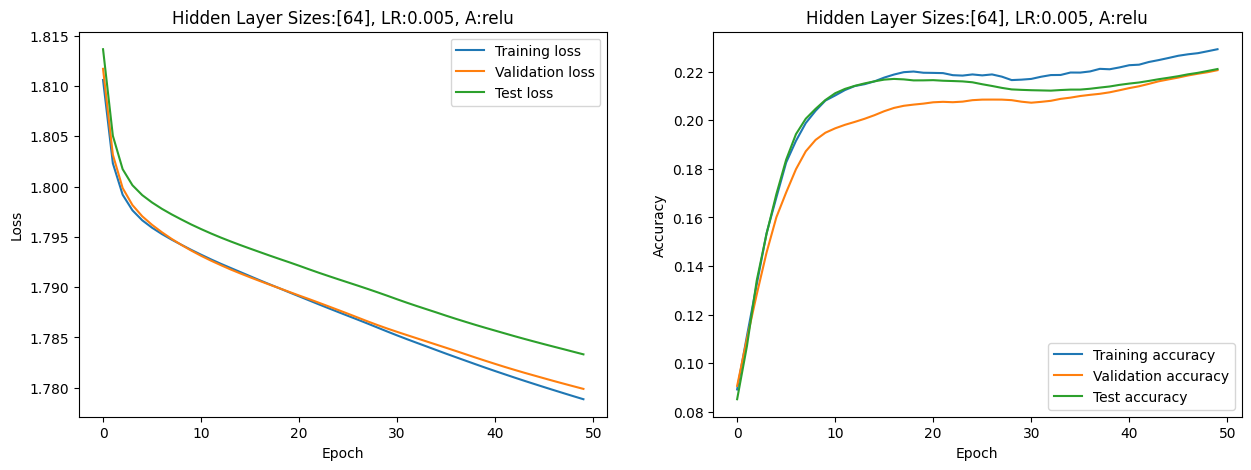


EXPERIMENT for MLP: 17
-------------
Hidden Layer Sizes:[64], LR:0.02, A:sigmoid


Epoch 10/50:
Train Loss:	1.7875	Train Accuracy:	29.31%
Val. Loss:	1.7888	Val. Accuracy:	29.98%
Test Loss:	1.7882	Test Accuracy:	28.73%

Epoch 20/50:
Train Loss:	1.7849	Train Accuracy:	30.06%
Val. Loss:	1.7863	Val. Accuracy:	30.96%
Test Loss:	1.7859	Test Accuracy:	29.75%

Epoch 30/50:
Train Loss:	1.7825	Train Accuracy:	30.30%
Val. Loss:	1.7838	Val. Accuracy:	31.10%
Test Loss:	1.7837	Test Accuracy:	29.80%

Epoch 40/50:
Train Loss:	1.7802	Train Accuracy:	30.50%
Val. Loss:	1.7815	Val. Accuracy:	31.16%
Test Loss:	1.7816	Test Accuracy:	29.96%

Epoch 50/50:
Train Loss:	1.7780	Train Accuracy:	30.61%
Val. Loss:	1.7793	Val. Accuracy:	31.21%
Test Loss:	1.7796	Test Accuracy:	30.11%


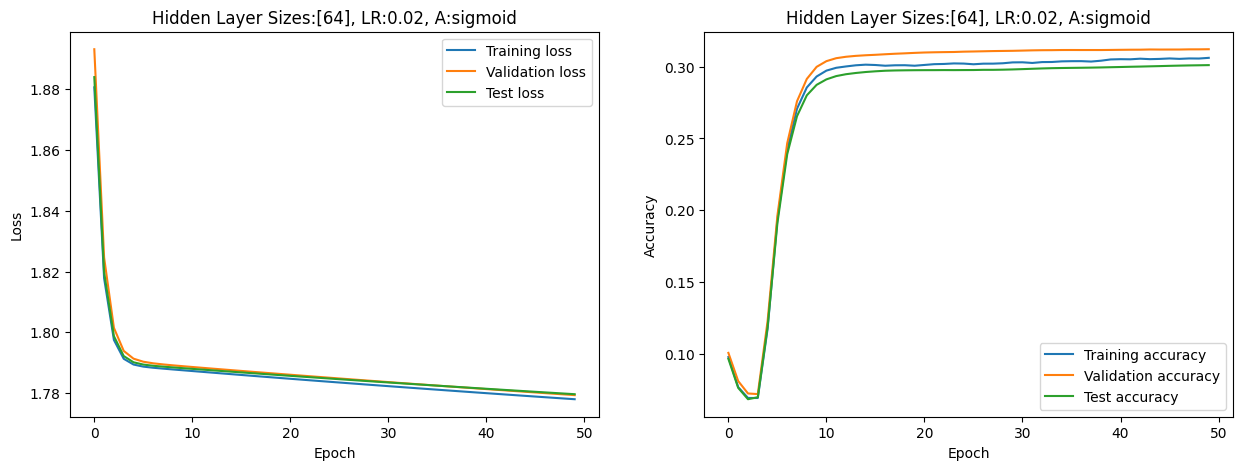


EXPERIMENT for MLP: 18
-------------
Hidden Layer Sizes:[64], LR:0.02, A:relu


Epoch 10/50:
Train Loss:	1.7832	Train Accuracy:	22.30%
Val. Loss:	1.7835	Val. Accuracy:	21.25%
Test Loss:	1.7867	Test Accuracy:	21.71%

Epoch 20/50:
Train Loss:	1.7723	Train Accuracy:	24.56%
Val. Loss:	1.7738	Val. Accuracy:	24.13%
Test Loss:	1.7772	Test Accuracy:	23.89%

Epoch 30/50:
Train Loss:	1.7637	Train Accuracy:	26.20%
Val. Loss:	1.7660	Val. Accuracy:	26.35%
Test Loss:	1.7696	Test Accuracy:	25.53%

Epoch 40/50:
Train Loss:	1.7559	Train Accuracy:	26.84%
Val. Loss:	1.7589	Val. Accuracy:	27.15%
Test Loss:	1.7626	Test Accuracy:	26.07%

Epoch 50/50:
Train Loss:	1.7487	Train Accuracy:	26.66%
Val. Loss:	1.7525	Val. Accuracy:	27.20%
Test Loss:	1.7568	Test Accuracy:	26.06%


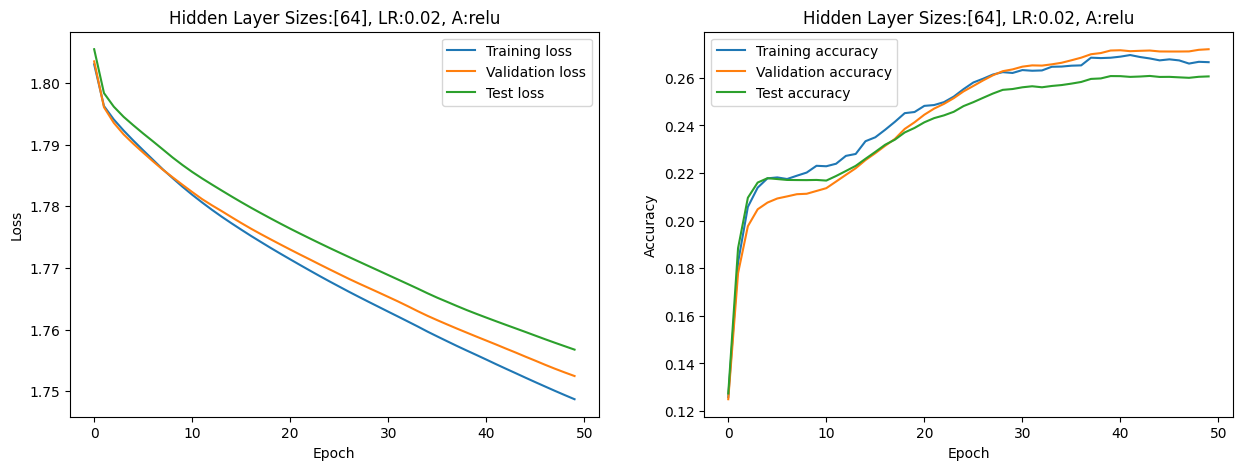


EXPERIMENT for MLP: 19
-------------
Hidden Layer Sizes:[32, 16], LR:0.005, A:sigmoid


Epoch 10/50:
Train Loss:	1.8672	Train Accuracy:	0.00%
Val. Loss:	1.8577	Val. Accuracy:	0.00%
Test Loss:	1.8649	Test Accuracy:	0.00%

Epoch 20/50:
Train Loss:	1.8187	Train Accuracy:	0.09%
Val. Loss:	1.8130	Val. Accuracy:	0.07%
Test Loss:	1.8170	Test Accuracy:	0.13%

Epoch 30/50:
Train Loss:	1.8036	Train Accuracy:	1.45%
Val. Loss:	1.8002	Val. Accuracy:	1.27%
Test Loss:	1.8024	Test Accuracy:	1.40%

Epoch 40/50:
Train Loss:	1.7980	Train Accuracy:	7.24%
Val. Loss:	1.7960	Val. Accuracy:	6.99%
Test Loss:	1.7970	Test Accuracy:	7.14%

Epoch 50/50:
Train Loss:	1.7956	Train Accuracy:	14.53%
Val. Loss:	1.7946	Val. Accuracy:	15.11%
Test Loss:	1.7949	Test Accuracy:	14.79%


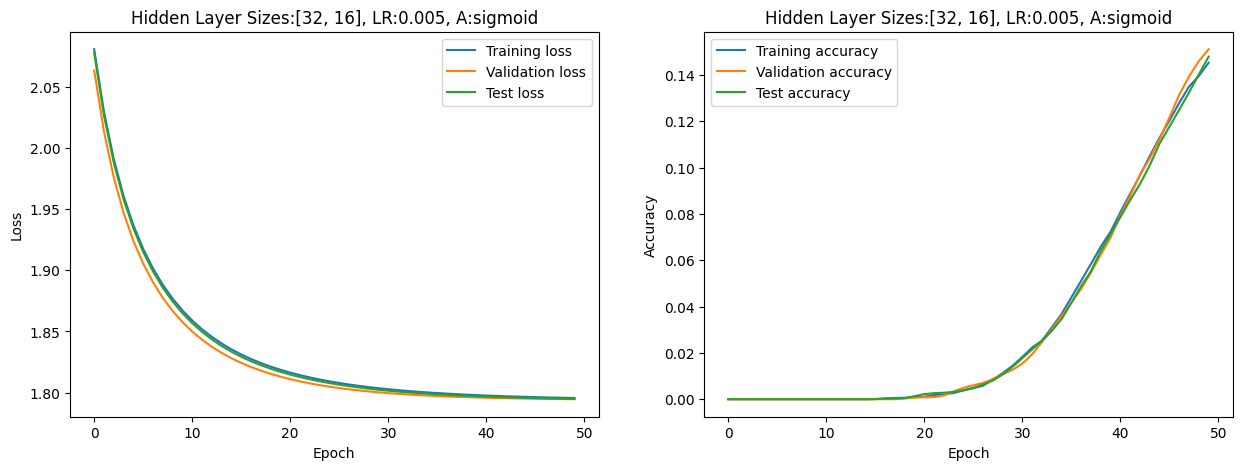


EXPERIMENT for MLP: 20
-------------
Hidden Layer Sizes:[32, 16], LR:0.005, A:relu


Epoch 10/50:
Train Loss:	1.7971	Train Accuracy:	33.44%
Val. Loss:	1.7950	Val. Accuracy:	32.86%
Test Loss:	1.7985	Test Accuracy:	33.89%

Epoch 20/50:
Train Loss:	1.7934	Train Accuracy:	34.15%
Val. Loss:	1.7915	Val. Accuracy:	33.49%
Test Loss:	1.7955	Test Accuracy:	34.15%

Epoch 30/50:
Train Loss:	1.7905	Train Accuracy:	33.92%
Val. Loss:	1.7895	Val. Accuracy:	33.09%
Test Loss:	1.7929	Test Accuracy:	33.03%

Epoch 40/50:
Train Loss:	1.7876	Train Accuracy:	34.75%
Val. Loss:	1.7867	Val. Accuracy:	34.00%
Test Loss:	1.7902	Test Accuracy:	34.23%

Epoch 50/50:
Train Loss:	1.7855	Train Accuracy:	34.12%
Val. Loss:	1.7852	Val. Accuracy:	33.16%
Test Loss:	1.7885	Test Accuracy:	34.02%


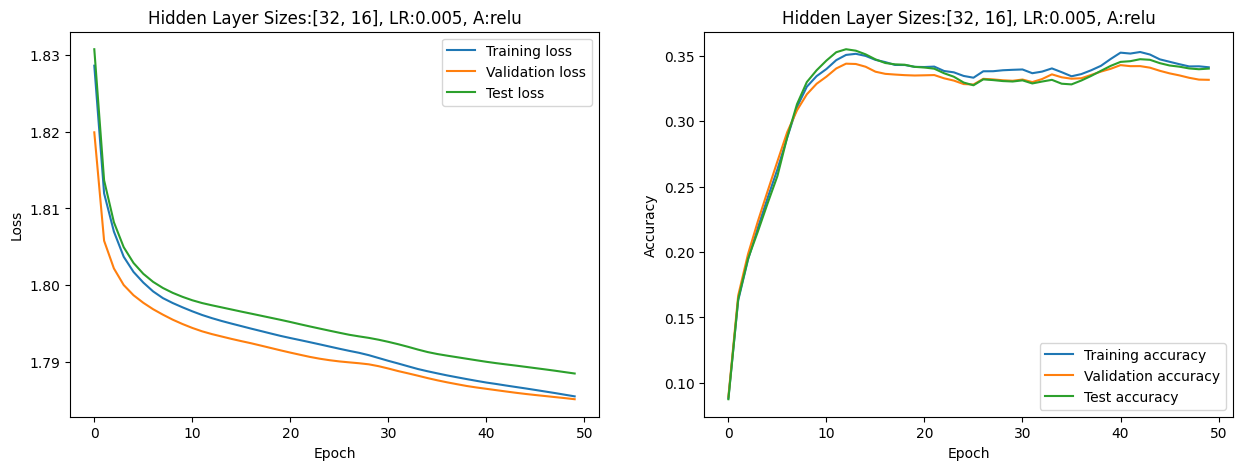


EXPERIMENT for MLP: 21
-------------
Hidden Layer Sizes:[32, 16], LR:0.02, A:sigmoid


Epoch 10/50:
Train Loss:	1.7986	Train Accuracy:	6.42%
Val. Loss:	1.7964	Val. Accuracy:	6.17%
Test Loss:	1.7976	Test Accuracy:	6.24%

Epoch 20/50:
Train Loss:	1.7936	Train Accuracy:	20.93%
Val. Loss:	1.7938	Val. Accuracy:	21.35%
Test Loss:	1.7931	Test Accuracy:	21.22%

Epoch 30/50:
Train Loss:	1.7924	Train Accuracy:	15.72%
Val. Loss:	1.7931	Val. Accuracy:	15.98%
Test Loss:	1.7921	Test Accuracy:	15.50%

Epoch 40/50:
Train Loss:	1.7914	Train Accuracy:	15.79%
Val. Loss:	1.7922	Val. Accuracy:	16.33%
Test Loss:	1.7912	Test Accuracy:	16.00%

Epoch 50/50:
Train Loss:	1.7904	Train Accuracy:	18.72%
Val. Loss:	1.7913	Val. Accuracy:	19.17%
Test Loss:	1.7904	Test Accuracy:	18.70%


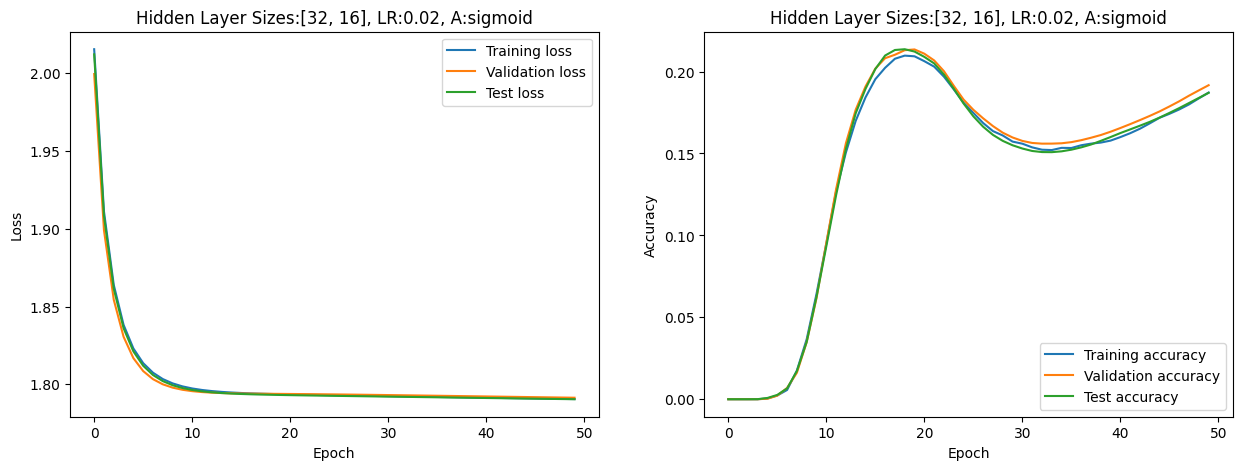


EXPERIMENT for MLP: 22
-------------
Hidden Layer Sizes:[32, 16], LR:0.02, A:relu


Epoch 10/50:
Train Loss:	1.7884	Train Accuracy:	32.87%
Val. Loss:	1.7874	Val. Accuracy:	32.51%
Test Loss:	1.7908	Test Accuracy:	32.84%

Epoch 20/50:
Train Loss:	1.7810	Train Accuracy:	32.47%
Val. Loss:	1.7817	Val. Accuracy:	31.97%
Test Loss:	1.7848	Test Accuracy:	32.08%

Epoch 30/50:
Train Loss:	1.7750	Train Accuracy:	31.17%
Val. Loss:	1.7775	Val. Accuracy:	31.21%
Test Loss:	1.7792	Test Accuracy:	30.74%

Epoch 40/50:
Train Loss:	1.7690	Train Accuracy:	31.10%
Val. Loss:	1.7729	Val. Accuracy:	31.27%
Test Loss:	1.7740	Test Accuracy:	30.52%

Epoch 50/50:
Train Loss:	1.7631	Train Accuracy:	30.44%
Val. Loss:	1.7683	Val. Accuracy:	31.01%
Test Loss:	1.7689	Test Accuracy:	30.05%


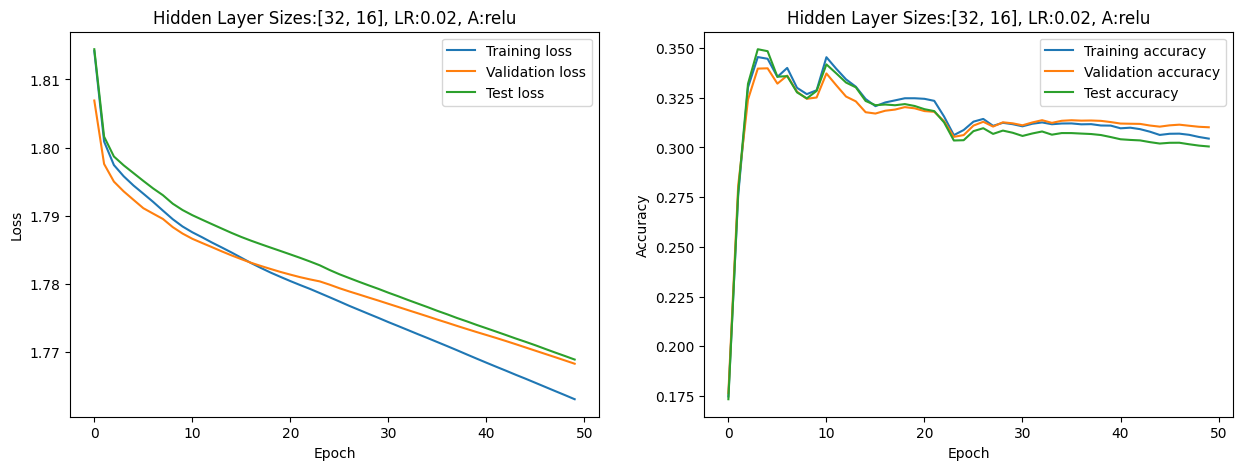


EXPERIMENT for MLP: 23
-------------
Hidden Layer Sizes:[64, 32], LR:0.005, A:sigmoid


Epoch 10/50:
Train Loss:	1.8327	Train Accuracy:	0.00%
Val. Loss:	1.8378	Val. Accuracy:	0.00%
Test Loss:	1.8339	Test Accuracy:	0.00%

Epoch 20/50:
Train Loss:	1.8018	Train Accuracy:	0.00%
Val. Loss:	1.8044	Val. Accuracy:	0.00%
Test Loss:	1.8025	Test Accuracy:	0.01%

Epoch 30/50:
Train Loss:	1.7928	Train Accuracy:	0.70%
Val. Loss:	1.7943	Val. Accuracy:	0.67%
Test Loss:	1.7933	Test Accuracy:	0.67%

Epoch 40/50:
Train Loss:	1.7904	Train Accuracy:	2.83%
Val. Loss:	1.7914	Val. Accuracy:	2.92%
Test Loss:	1.7907	Test Accuracy:	2.72%

Epoch 50/50:
Train Loss:	1.7896	Train Accuracy:	6.25%
Val. Loss:	1.7903	Val. Accuracy:	6.33%
Test Loss:	1.7899	Test Accuracy:	6.73%


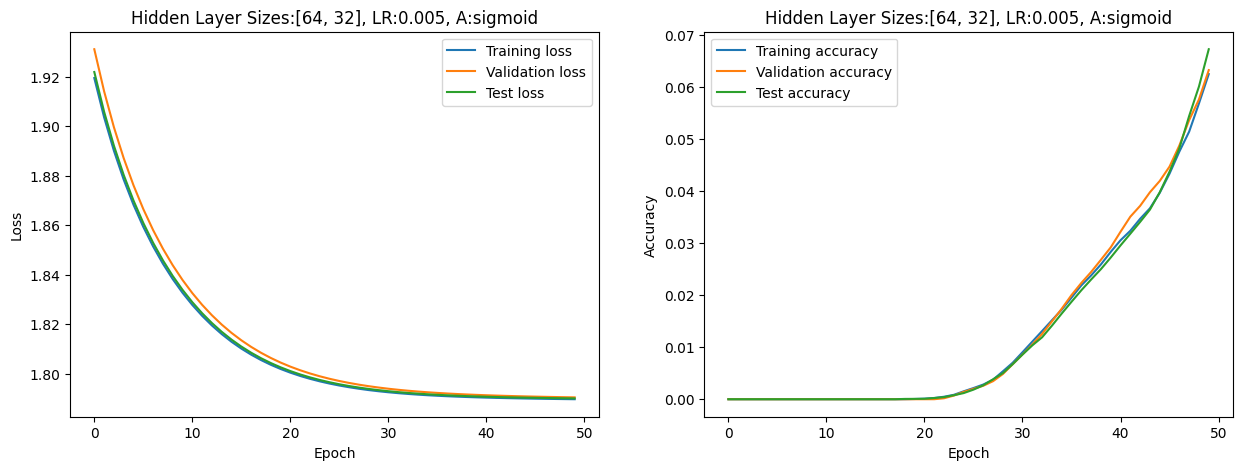


EXPERIMENT for MLP: 24
-------------
Hidden Layer Sizes:[64, 32], LR:0.005, A:relu


Epoch 10/50:
Train Loss:	1.7975	Train Accuracy:	3.31%
Val. Loss:	1.7992	Val. Accuracy:	2.86%
Test Loss:	1.8013	Test Accuracy:	3.15%

Epoch 20/50:
Train Loss:	1.7925	Train Accuracy:	7.55%
Val. Loss:	1.7931	Val. Accuracy:	6.85%
Test Loss:	1.7963	Test Accuracy:	7.91%

Epoch 30/50:
Train Loss:	1.7893	Train Accuracy:	13.32%
Val. Loss:	1.7896	Val. Accuracy:	12.24%
Test Loss:	1.7928	Test Accuracy:	13.59%

Epoch 40/50:
Train Loss:	1.7865	Train Accuracy:	18.02%
Val. Loss:	1.7866	Val. Accuracy:	16.57%
Test Loss:	1.7902	Test Accuracy:	18.46%

Epoch 50/50:
Train Loss:	1.7839	Train Accuracy:	19.82%
Val. Loss:	1.7836	Val. Accuracy:	18.54%
Test Loss:	1.7878	Test Accuracy:	20.33%


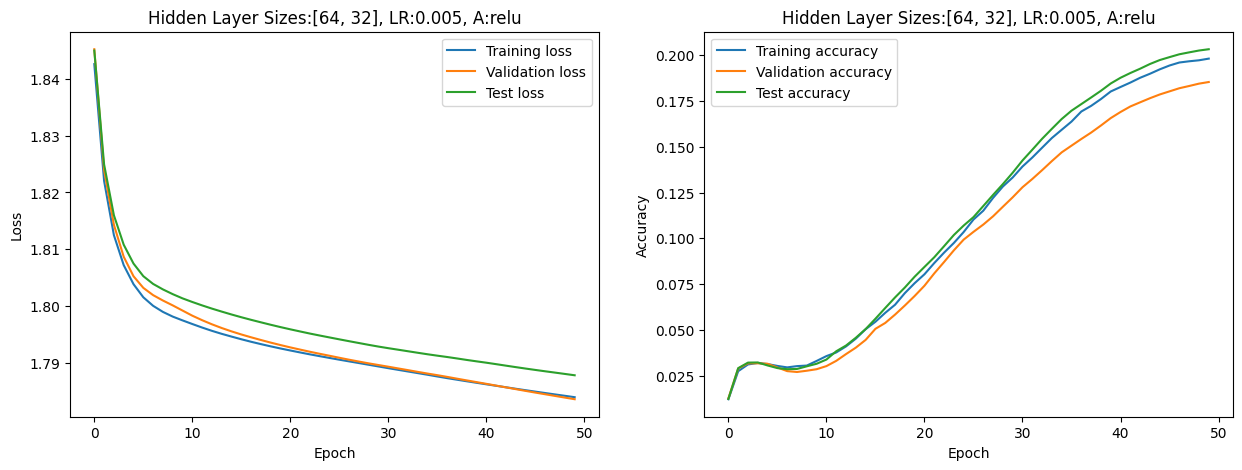


EXPERIMENT for MLP: 25
-------------
Hidden Layer Sizes:[64, 32], LR:0.02, A:sigmoid


Epoch 10/50:
Train Loss:	1.7906	Train Accuracy:	2.52%
Val. Loss:	1.7916	Val. Accuracy:	2.58%
Test Loss:	1.7910	Test Accuracy:	2.43%

Epoch 20/50:
Train Loss:	1.7889	Train Accuracy:	22.00%
Val. Loss:	1.7893	Val. Accuracy:	22.48%
Test Loss:	1.7891	Test Accuracy:	21.91%

Epoch 30/50:
Train Loss:	1.7879	Train Accuracy:	24.17%
Val. Loss:	1.7883	Val. Accuracy:	24.56%
Test Loss:	1.7883	Test Accuracy:	23.90%

Epoch 40/50:
Train Loss:	1.7871	Train Accuracy:	23.42%
Val. Loss:	1.7874	Val. Accuracy:	23.76%
Test Loss:	1.7876	Test Accuracy:	22.92%

Epoch 50/50:
Train Loss:	1.7863	Train Accuracy:	22.43%
Val. Loss:	1.7866	Val. Accuracy:	22.77%
Test Loss:	1.7869	Test Accuracy:	21.93%


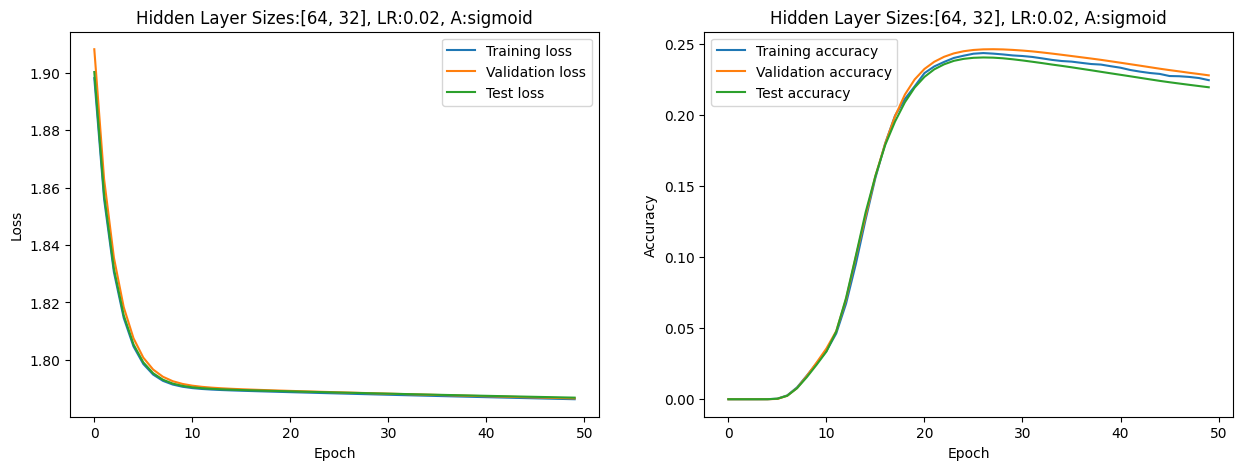


EXPERIMENT for MLP: 26
-------------
Hidden Layer Sizes:[64, 32], LR:0.02, A:relu


Epoch 10/50:
Train Loss:	1.7874	Train Accuracy:	17.24%
Val. Loss:	1.7873	Val. Accuracy:	16.15%
Test Loss:	1.7909	Test Accuracy:	17.69%

Epoch 20/50:
Train Loss:	1.7781	Train Accuracy:	20.44%
Val. Loss:	1.7769	Val. Accuracy:	20.08%
Test Loss:	1.7816	Test Accuracy:	20.78%

Epoch 30/50:
Train Loss:	1.7693	Train Accuracy:	19.72%
Val. Loss:	1.7680	Val. Accuracy:	19.62%
Test Loss:	1.7735	Test Accuracy:	20.25%

Epoch 40/50:
Train Loss:	1.7602	Train Accuracy:	20.81%
Val. Loss:	1.7599	Val. Accuracy:	21.03%
Test Loss:	1.7655	Test Accuracy:	21.03%

Epoch 50/50:
Train Loss:	1.7516	Train Accuracy:	22.04%
Val. Loss:	1.7528	Val. Accuracy:	22.17%
Test Loss:	1.7584	Test Accuracy:	22.04%


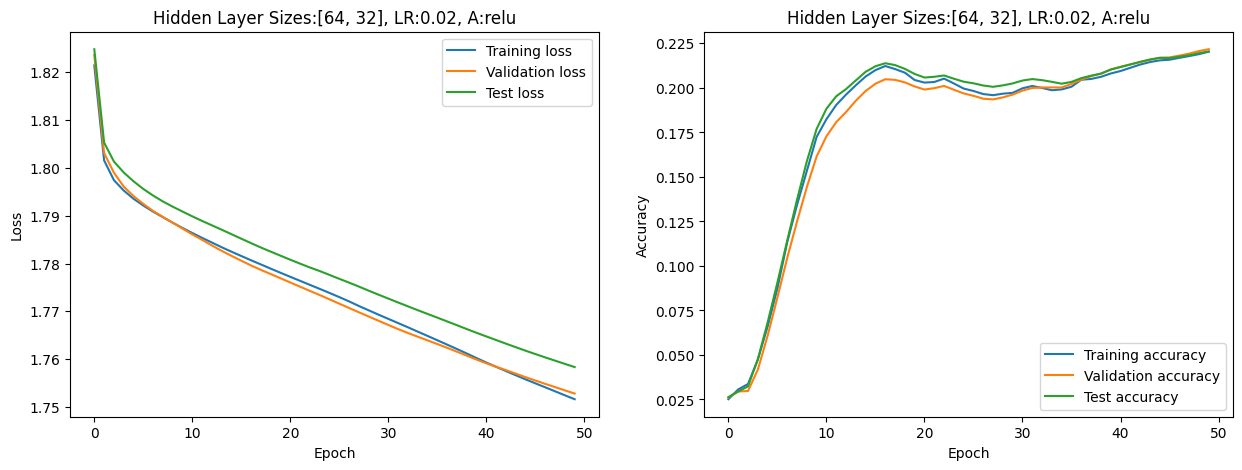


EXPERIMENT for MLP: 27
-------------
Hidden Layer Sizes:[128, 64], LR:0.005, A:sigmoid


Epoch 10/50:
Train Loss:	1.8160	Train Accuracy:	0.00%
Val. Loss:	1.8164	Val. Accuracy:	0.00%
Test Loss:	1.8150	Test Accuracy:	0.00%

Epoch 20/50:
Train Loss:	1.7928	Train Accuracy:	2.32%
Val. Loss:	1.7930	Val. Accuracy:	2.06%
Test Loss:	1.7918	Test Accuracy:	2.20%

Epoch 30/50:
Train Loss:	1.7910	Train Accuracy:	10.31%
Val. Loss:	1.7910	Val. Accuracy:	10.54%
Test Loss:	1.7900	Test Accuracy:	10.32%

Epoch 40/50:
Train Loss:	1.7904	Train Accuracy:	10.49%
Val. Loss:	1.7904	Val. Accuracy:	10.99%
Test Loss:	1.7895	Test Accuracy:	10.58%

Epoch 50/50:
Train Loss:	1.7900	Train Accuracy:	10.28%
Val. Loss:	1.7899	Val. Accuracy:	10.79%
Test Loss:	1.7891	Test Accuracy:	10.13%


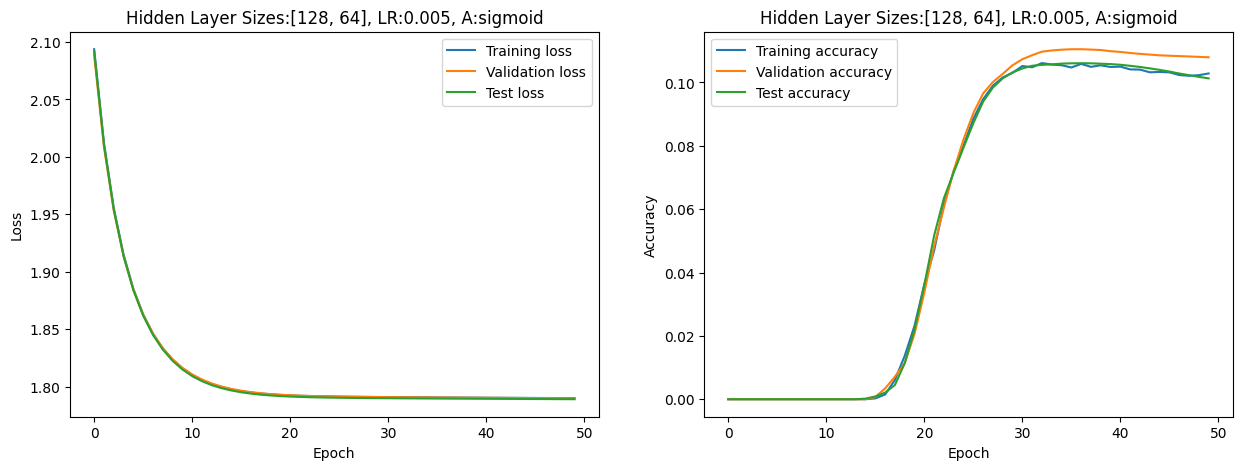


EXPERIMENT for MLP: 28
-------------
Hidden Layer Sizes:[128, 64], LR:0.005, A:relu


Epoch 10/50:
Train Loss:	1.7891	Train Accuracy:	15.82%
Val. Loss:	1.7867	Val. Accuracy:	15.64%
Test Loss:	1.7895	Test Accuracy:	15.30%

Epoch 20/50:
Train Loss:	1.7841	Train Accuracy:	18.84%
Val. Loss:	1.7827	Val. Accuracy:	19.09%
Test Loss:	1.7851	Test Accuracy:	19.76%

Epoch 30/50:
Train Loss:	1.7799	Train Accuracy:	20.08%
Val. Loss:	1.7786	Val. Accuracy:	20.42%
Test Loss:	1.7810	Test Accuracy:	20.69%

Epoch 40/50:
Train Loss:	1.7762	Train Accuracy:	20.61%
Val. Loss:	1.7748	Val. Accuracy:	21.17%
Test Loss:	1.7777	Test Accuracy:	20.96%

Epoch 50/50:
Train Loss:	1.7730	Train Accuracy:	21.39%
Val. Loss:	1.7716	Val. Accuracy:	21.55%
Test Loss:	1.7749	Test Accuracy:	21.10%


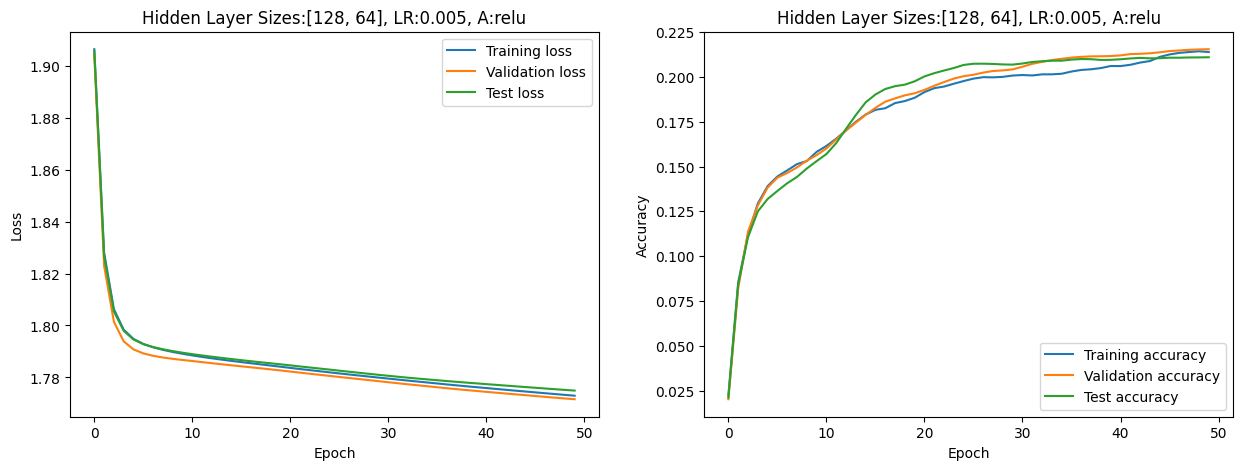


EXPERIMENT for MLP: 29
-------------
Hidden Layer Sizes:[128, 64], LR:0.02, A:sigmoid


Epoch 10/50:
Train Loss:	1.7907	Train Accuracy:	11.24%
Val. Loss:	1.7904	Val. Accuracy:	11.84%
Test Loss:	1.7896	Test Accuracy:	11.27%

Epoch 20/50:
Train Loss:	1.7889	Train Accuracy:	10.48%
Val. Loss:	1.7886	Val. Accuracy:	11.44%
Test Loss:	1.7879	Test Accuracy:	10.42%

Epoch 30/50:
Train Loss:	1.7872	Train Accuracy:	11.96%
Val. Loss:	1.7868	Val. Accuracy:	12.67%
Test Loss:	1.7864	Test Accuracy:	11.63%

Epoch 40/50:
Train Loss:	1.7856	Train Accuracy:	13.87%
Val. Loss:	1.7852	Val. Accuracy:	14.93%
Test Loss:	1.7850	Test Accuracy:	13.87%

Epoch 50/50:
Train Loss:	1.7842	Train Accuracy:	15.63%
Val. Loss:	1.7837	Val. Accuracy:	17.38%
Test Loss:	1.7838	Test Accuracy:	16.09%


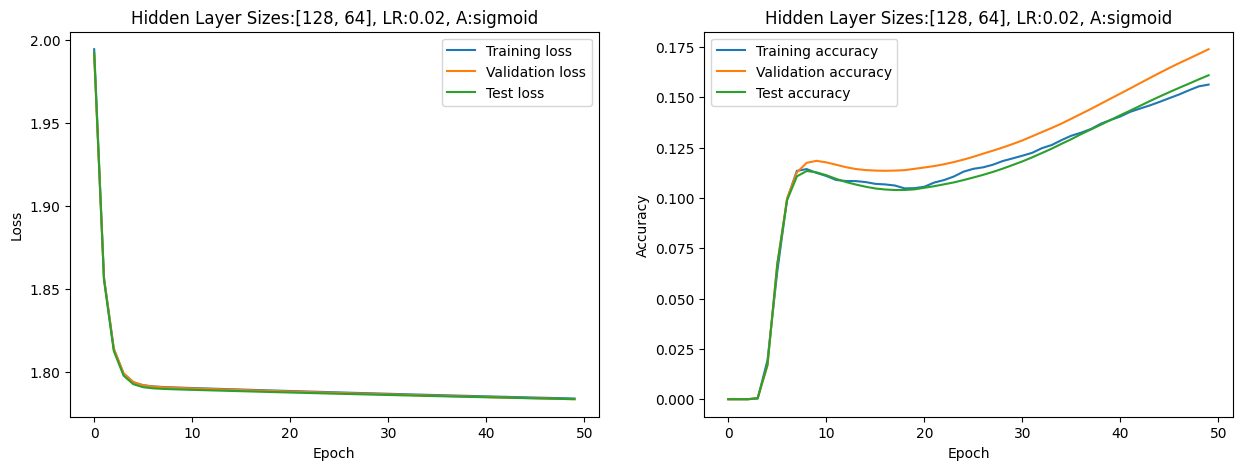


EXPERIMENT for MLP: 30
-------------
Hidden Layer Sizes:[128, 64], LR:0.02, A:relusigmoid


Epoch 10/50:
Train Loss:	1.7773	Train Accuracy:	20.15%
Val. Loss:	1.7758	Val. Accuracy:	21.05%
Test Loss:	1.7783	Test Accuracy:	21.13%

Epoch 20/50:
Train Loss:	1.7652	Train Accuracy:	21.64%
Val. Loss:	1.7645	Val. Accuracy:	22.16%
Test Loss:	1.7687	Test Accuracy:	21.58%

Epoch 30/50:
Train Loss:	1.7549	Train Accuracy:	23.67%
Val. Loss:	1.7549	Val. Accuracy:	24.08%
Test Loss:	1.7607	Test Accuracy:	23.17%

Epoch 40/50:
Train Loss:	1.7451	Train Accuracy:	24.49%
Val. Loss:	1.7468	Val. Accuracy:	25.13%
Test Loss:	1.7530	Test Accuracy:	23.87%

Epoch 50/50:
Train Loss:	1.7355	Train Accuracy:	24.64%
Val. Loss:	1.7396	Val. Accuracy:	25.52%
Test Loss:	1.7449	Test Accuracy:	24.20%


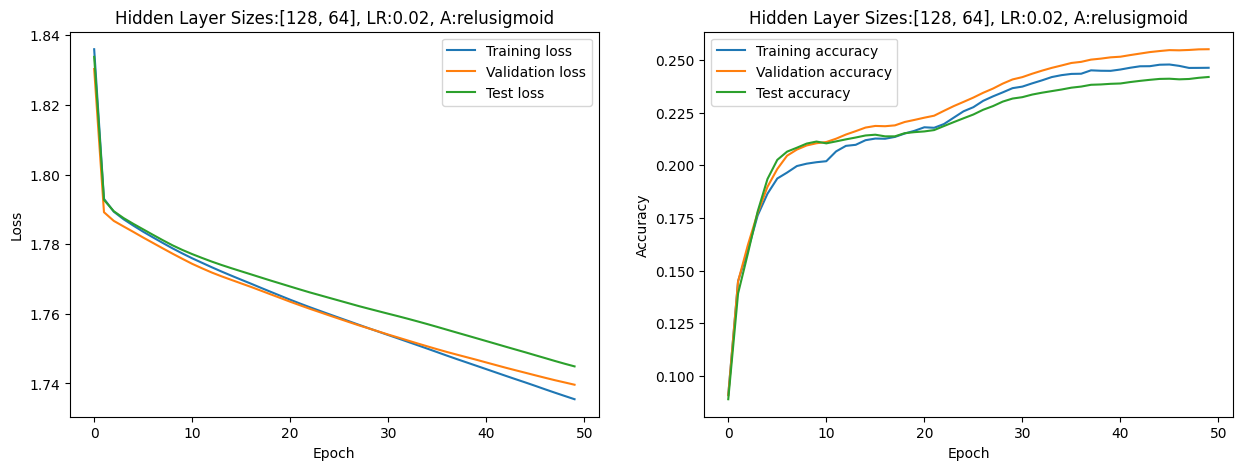

In [9]:
results = mlp_experiments(X_train_flatten, y_train, X_test_flatten, y_test, X_val_flatten, y_val)

mlp_results_df = pd.DataFrame(results)


In [11]:
mlp_results_df.set_index("Experiments", inplace=True)
mlp_results_df

Input Size Activation Hidden Layer Size  Learning Rate  \
Experiments                                                          
1                32x32    sigmoid                []          0.005   
2                32x32       relu                []          0.005   
3                32x32    sigmoid                []          0.005   
4                32x32       relu                []          0.020   
5                32x32    sigmoid                []          0.020   
6                32x32       relu                []          0.020   
7                32x32    sigmoid              [16]          0.005   
8                32x32       relu              [16]          0.005   
9                32x32    sigmoid              [16]          0.020   
10               32x32       relu              [16]          0.020   
11               32x32    sigmoid              [32]          0.005   
12               32x32       relu              [32]          0.005   
13               32x32    sigmoid              [32]          0.020   
14               32x32       relu              [32]          0.020   
15               32x32    sigmoid              [64]          0.005   
16               32x32       relu              [64]          0.005   
17               32x32    sigmoid              [64]          0.020   
18               32x32       relu              [64]          0.020   
19               32x32    sigmoid          [32, 16]          0.005   
20               32x32       relu          [32, 16]          0.005   
21               32x32    sigmoid          [32, 16]          0.020   
22               32x32       relu          [32, 16]          0.020   
23               32x32    sigmoid          [64, 32]          0.005   
24               32x32       relu          [64, 32]          0.005   
25               32x32    sigmoid          [64, 32]          0.020   
26               32x32       relu          [64, 32]          0.020   
27               32x32    sigmoid         [128, 64]          0.005   
28               32x32       relu         [128, 64]          0.005   
29               32x32    sigmoid         [128, 64]          0.020   
30               32x32       relu         [128, 64]          0.020   

             Batch Size  Epoch  Accuracy  
Experiments                               
1                    16     50    0.2327  
2                    32     50    0.2327  
3                    64     50    0.2327  
4                    16     50    0.2763  
5                    32     50    0.2762  
6                    64     50    0.2763  
7                    16     50    0.0874  
8                    32     50    0.3749  
9                    16     50    0.1848  
10                   32     50    0.3289  
11                   16     50    0.2717  
12                   32     50    0.3104  
13                   16     50    0.3150  
14                   32     50    0.2887  
15                   16     50    0.2975  
16                   32     50    0.2211  
17                   16     50    0.3011  
18                   32     50    0.2606  
19                   16     50    0.1479  
20                   32     50    0.3402  
21                   16     50    0.1870  
22                   32     50    0.3005  
23                   16     50    0.0673  
24                   32     50    0.2033  
25                   16     50    0.2193  
26                   32     50    0.2204  
27                   16     50    0.1013  
28                   32     50    0.2110  
29                   16     50    0.1609  
30                   32     50    0.2420

# Analysis of MLP Results

***Activation Function:***
In simple neural network architecture, the activation functions sigmoid and relu are not used so it has no impact on these experiments.
In the other experiment results, we can clearly see the relu activation provides way more better accuracies than the sigmoid activation.

***Hidden Layer Sizes:***
We get the best accuracies when there is 1 hidden layers, and similar accuracies in no hidden layers and 2 hidden layers, and also greater sizes in hidden layers usually improves performance since the complexity of model's learning increases.

***Learning Rate:***
Higher learning rate values almost always generate a better accuracy in the results, so we can say that increaseness of learning rate is important to improve the model's performance usually.

***Batch Sizes:***
In simple architecture, it has no impact but in 1 layer models it decreases the accuracy while it increases in the 2 layer models. We can say that in 1 layers, smaller batches helps the model to perform better by frequently updating the weights while it might be causing overfitting in 2 layer models.

# PART 2: CONVOLUTIONAL NEURAL NETWORK

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

In [2]:
def CNN(num_conv_layers,hidden_layer_sizes, activation_func, num_classes):
    model = nn.Sequential()

    for i in range(num_conv_layers):
        if i == 0:
            model.add_module("c1", nn.Conv2d(1,32, kernel_size=3,stride=1))
            model.add_module("a1", activation_func)
        else:
            model.add_module("c2", nn.Conv2d(32,8, kernel_size=3, stride=1))
            model.add_module("a2", activation_func)
    model.add_module("pool", nn.MaxPool2d(kernel_size=2, stride=4))
    model.add_module("flat", nn.Flatten())

    for i in range(len(hidden_layer_sizes)):
        if i == 0:
            if num_conv_layers == 1:
                model.add_module("l1", nn.Linear(32*8*8, hidden_layer_sizes[i]))
            else:
                model.add_module("l2", nn.Linear(7*7*8, hidden_layer_sizes[i]))
            model.add_module("a3", activation_func)
        else:
            model.add_module("l3", nn.Linear(hidden_layer_sizes[i - 1], hidden_layer_sizes[i]))
            model.add_module("a4", activation_func)
    model.add_module("l5", nn.Linear(hidden_layer_sizes[-1], num_classes))
    model.add_module("s", nn.Softmax())

    return model

In [3]:
def trainCNN(X_train, y_train, X_val, y_val, X_test, y_test, num_conv_layers, hidden_layer_sizes, activation_func, learning_rate, epochs, batch_size, num_classes):
    model = CNN(num_conv_layers, hidden_layer_sizes, activation_func, num_classes)
    optimizer = optim.AdamW(model.parameters(), lr= learning_rate)
    criterion = nn.CrossEntropyLoss()
    training_history = {'loss': [], 'accuracy': []}
    validation_history = {'loss': [], 'accuracy': []}
    test_history = {'loss': [], 'accuracy': []}

    for epoch in range(1, epochs + 1):
        train_loss = 0
        correct_train = 0
        total_train = 0

        for i in range(0, X_train.shape[0], batch_size):
            X_batch = X_train[i : i + batch_size].reshape(-1, 1, 32, 32)
            y_batch = y_train[i : i + batch_size]
            X = torch.autograd.Variable(torch.Tensor(X_batch))
            y = torch.autograd.Variable(torch.Tensor(y_batch), requires_grad=False)
            
            output_train = model(X)
            loss = criterion(output_train, torch.max(y, 1)[1])
            train_loss += loss.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            _, predicted_train = torch.max(output_train.data, 1)
            total_train += y.size(0)
            correct_train += (predicted_train == torch.max(y, 1)[1]).sum().item()

        training_history['loss'].append(loss.item())
        train_accuracy = correct_train / total_train
        training_history['accuracy'].append(train_accuracy)


        X_val = X_val.reshape(-1, 1, 32, 32)
        X_v = torch.autograd.Variable(torch.Tensor(X_val))
        y_v = torch.autograd.Variable(torch.Tensor(y_val), requires_grad=False)
        output_val = model(X_v)
        val_loss = criterion(output_val, torch.max(y_v, 1)[1])
        validation_history['loss'].append(val_loss.item())

        _, predicted_val = torch.max(output_val.data, 1)
        val_accuracy = (predicted_val == torch.max(y_v, 1)[1]).sum().item() / len(y_val)
        validation_history['accuracy'].append(val_accuracy)

       
        X_test = X_test.reshape(-1, 1, 32, 32)
        X_t = torch.autograd.Variable(torch.Tensor(X_test))
        y_t = torch.autograd.Variable(torch.Tensor(y_test), requires_grad=False)
        output_test = model(X_t)
        test_loss = criterion(output_test, torch.max(y_t, 1)[1])
        test_history['loss'].append(test_loss.item())

        _, predicted_test = torch.max(output_test.data, 1)
        test_accuracy = (predicted_test == torch.max(y_t, 1)[1]).sum().item() / len(y_test)
        test_history['accuracy'].append(test_accuracy)

        if epoch % 10 == 0:
            print(f'\nEpoch {epoch}/{epochs}:\nTrain Loss:\t{loss.item():.4f}\tTrain Accuracy:\t{(train_accuracy * 100):.2f}%\nVal. Loss:\t{val_loss.item():.4f}\tVal. Accuracy:\t{(val_accuracy * 100):.2f}%\nTest Loss:\t{test_loss.item():.4f}\tTest Accuracy:\t{(test_accuracy * 100):.2f}%')

    return training_history, validation_history, test_history

In [26]:
def experiment_CNN(X, y, X_val, y_val, X_test, y_test):
    input_size = "32x32"
    num_classes = 6
    epochs = 50

    num_experiments = 16

    conv_layers_list = [2,2,2,2,2,2,2,2,
                        1,1,1,1,1,1,1,1]

    hidden_sizes_list = [[512,256],[512,256],[256,128],[256,128],[256,128],[256,128],[128,64],[128,64],
                         [1024], [1024], [512], [512], [512], [512], [256], [256]]
    
    learning_rates_list = [0.01, 0.001, 0.01, 0.01, 0.001, 0.001, 0.01, 0.001,
                           0.01, 0.001, 0.01, 0.01, 0.001, 0.001, 0.01, 0.001]

    batch_sizes_list = [64, 64, 128, 64, 128, 64, 128, 128, 
                        64, 64, 128, 64, 128, 64, 128, 128]
    
    activation_functions_list = [nn.Sigmoid(), nn.ReLU(), nn.Sigmoid(), nn.ReLU(), nn.Sigmoid(), nn.ReLU(), nn.Sigmoid(), nn.ReLU(),
                                 nn.Sigmoid(), nn.ReLU(), nn.Sigmoid(), nn.ReLU(), nn.Sigmoid(), nn.ReLU(), nn.Sigmoid(), nn.ReLU(),]
    
    act_funcs_str = ["sigmoid","relu","sigmoid","relu","sigmoid","relu","sigmoid","relu",
                     "sigmoid","relu","sigmoid","relu","sigmoid","relu","sigmoid","relu"]
    
    results = {"Experiments": [i+1 for i in range(num_experiments)],
                "Input Size": [f'{input_size}' for i in range(num_experiments)],
                "Activation": activation_functions_list,
                "Conv. Layer Num": conv_layers_list,
                "Hidden Layer Size": hidden_sizes_list,
                "Learning Rate": learning_rates_list,
                "Batch Size": batch_sizes_list,
                "Epoch": [epochs for i in range(num_experiments)],
                "Accuracy": []}
    
    for i in range(num_experiments):
        print(f"\nEXPERIMENT for CNN: {i+1}\n-------------")
        print(f'Conv. Layer Sizes:{conv_layers_list[i]}, FC Layer Sizes:{hidden_sizes_list[i]}, LR:{learning_rates_list[i]}, A:{act_funcs_str[i]}\n')
    
        training_history, validation_history, test_history = trainCNN(X, y, X_val, y_val, X_test, y_test,
                                                                      conv_layers_list[i], hidden_sizes_list[i], activation_functions_list[i], learning_rates_list[i], epochs, batch_sizes_list[i], num_classes)
        accuracy = test_history['accuracy'][-1]
        results['Accuracy'].append(accuracy)

        fig, ax = plt.subplots(1,2, figsize=(15,5))
        
        ax[0].plot([i for i in range(epochs)], training_history['loss'], label="Training loss")
        ax[1].plot([i for i in range(epochs)], training_history['accuracy'], label="Training accuracy")
        ax[0].plot([i for i in range(epochs)], validation_history['loss'], label="Validation loss")
        ax[1].plot([i for i in range(epochs)], validation_history['accuracy'], label="Validation accuracy")
        ax[0].plot([i for i in range(epochs)], test_history['loss'], label="Test loss")
        ax[1].plot([i for i in range(epochs)], test_history['accuracy'], label="Test accuracy")
        ax[0].set_title(f"Conv. Layer Num.:{conv_layers_list[i]}, FC Layer Sizes:{hidden_sizes_list[i]}, Batch:{batch_sizes_list[i]}, LR:{learning_rates_list[i]}, A:{act_funcs_str[i]}")
        ax[1].set_title(f"Conv. Layer Num.:{conv_layers_list[i]}, FC Layer Sizes:{hidden_sizes_list[i]}, Batch:{batch_sizes_list[i]}, LR:{learning_rates_list[i]}, A:{act_funcs_str[i]}")
        ax[0].set_xlabel("Epoch")
        ax[0].set_ylabel("Loss")
        ax[1].set_xlabel("Epoch")
        ax[1].set_ylabel("Accuracy")
        ax[0].legend()
        ax[1].legend()
        plt.show()
        
    return results


EXPERIMENT for CNN: 1
-------------
Conv. Layer Sizes:2, FC Layer Sizes:[512, 256], LR:0.01, A:sigmoid


Epoch 10/50:
Train Loss:	1.8060	Train Accuracy:	17.19%
Val. Loss:	1.8059	Val. Accuracy:	17.24%
Test Loss:	1.8056	Test Accuracy:	16.67%

Epoch 20/50:
Train Loss:	1.8417	Train Accuracy:	16.95%
Val. Loss:	1.8583	Val. Accuracy:	16.67%
Test Loss:	1.8588	Test Accuracy:	16.67%

Epoch 30/50:
Train Loss:	1.7888	Train Accuracy:	15.92%
Val. Loss:	1.7940	Val. Accuracy:	16.25%
Test Loss:	1.7935	Test Accuracy:	16.67%

Epoch 40/50:
Train Loss:	1.7895	Train Accuracy:	16.50%
Val. Loss:	1.7928	Val. Accuracy:	16.25%
Test Loss:	1.7924	Test Accuracy:	16.67%

Epoch 50/50:
Train Loss:	1.7898	Train Accuracy:	16.51%
Val. Loss:	1.7925	Val. Accuracy:	16.25%
Test Loss:	1.7922	Test Accuracy:	16.67%


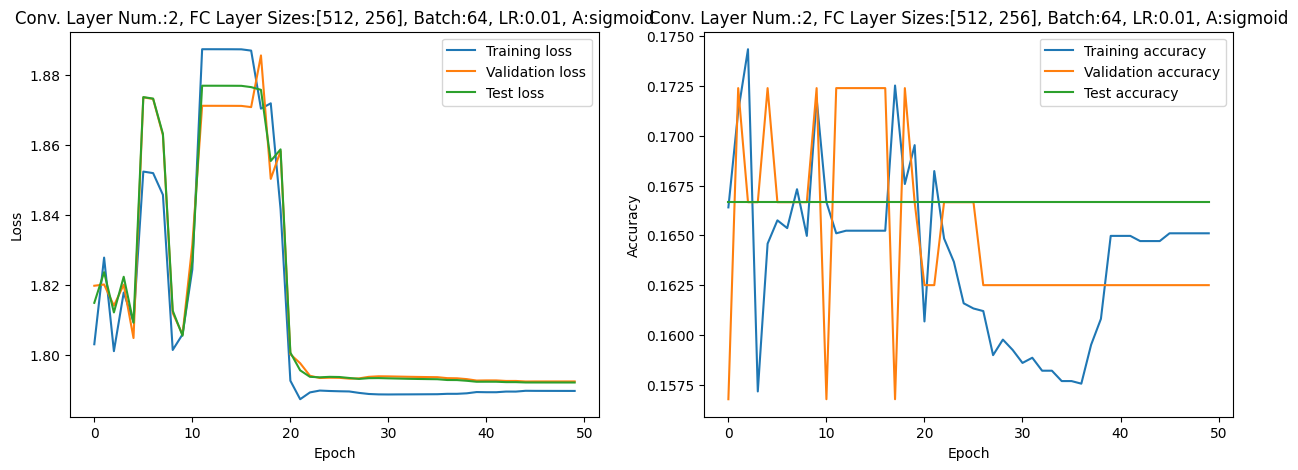


EXPERIMENT for CNN: 2
-------------
Conv. Layer Sizes:2, FC Layer Sizes:[512, 256], LR:0.001, A:relu


Epoch 10/50:
Train Loss:	1.6793	Train Accuracy:	33.10%
Val. Loss:	1.7073	Val. Accuracy:	31.51%
Test Loss:	1.7141	Test Accuracy:	30.92%

Epoch 20/50:
Train Loss:	1.6515	Train Accuracy:	41.37%
Val. Loss:	1.6966	Val. Accuracy:	32.97%
Test Loss:	1.7032	Test Accuracy:	32.04%

Epoch 30/50:
Train Loss:	1.5307	Train Accuracy:	46.90%
Val. Loss:	1.6924	Val. Accuracy:	33.59%
Test Loss:	1.6927	Test Accuracy:	33.38%

Epoch 40/50:
Train Loss:	1.4843	Train Accuracy:	51.99%
Val. Loss:	1.6723	Val. Accuracy:	35.83%
Test Loss:	1.6783	Test Accuracy:	35.17%

Epoch 50/50:
Train Loss:	1.5113	Train Accuracy:	58.36%
Val. Loss:	1.6706	Val. Accuracy:	36.25%
Test Loss:	1.6784	Test Accuracy:	35.00%


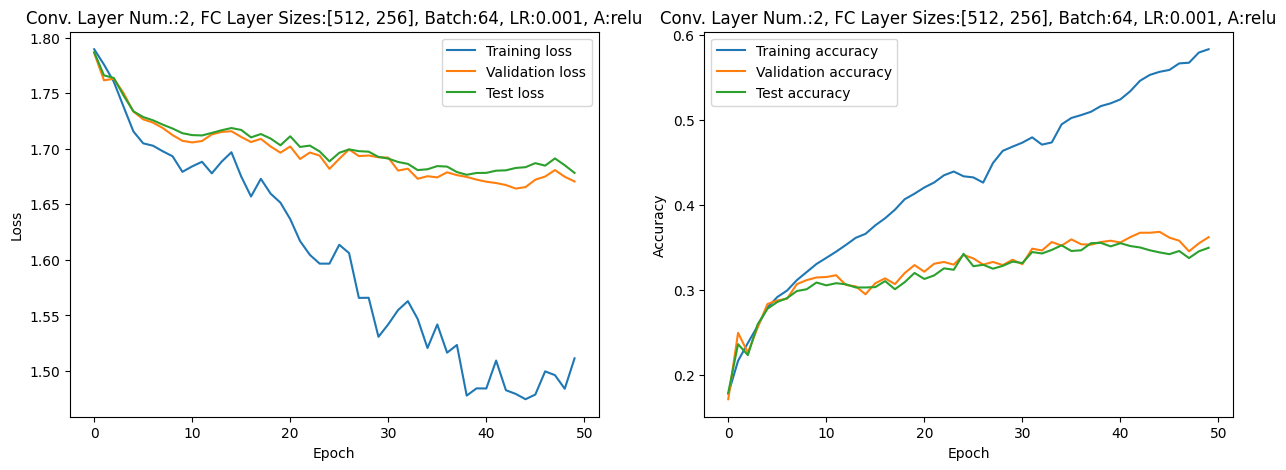


EXPERIMENT for CNN: 3
-------------
Conv. Layer Sizes:2, FC Layer Sizes:[256, 128], LR:0.01, A:sigmoid


Epoch 10/50:
Train Loss:	1.7930	Train Accuracy:	16.09%
Val. Loss:	1.7917	Val. Accuracy:	16.93%
Test Loss:	1.7919	Test Accuracy:	16.67%

Epoch 20/50:
Train Loss:	1.7924	Train Accuracy:	16.08%
Val. Loss:	1.7917	Val. Accuracy:	16.93%
Test Loss:	1.7918	Test Accuracy:	16.67%

Epoch 30/50:
Train Loss:	1.7921	Train Accuracy:	15.98%
Val. Loss:	1.7918	Val. Accuracy:	16.93%
Test Loss:	1.7918	Test Accuracy:	16.67%

Epoch 40/50:
Train Loss:	1.7919	Train Accuracy:	15.94%
Val. Loss:	1.7918	Val. Accuracy:	16.93%
Test Loss:	1.7918	Test Accuracy:	16.67%

Epoch 50/50:
Train Loss:	1.7915	Train Accuracy:	15.83%
Val. Loss:	1.7919	Val. Accuracy:	15.68%
Test Loss:	1.7918	Test Accuracy:	16.67%


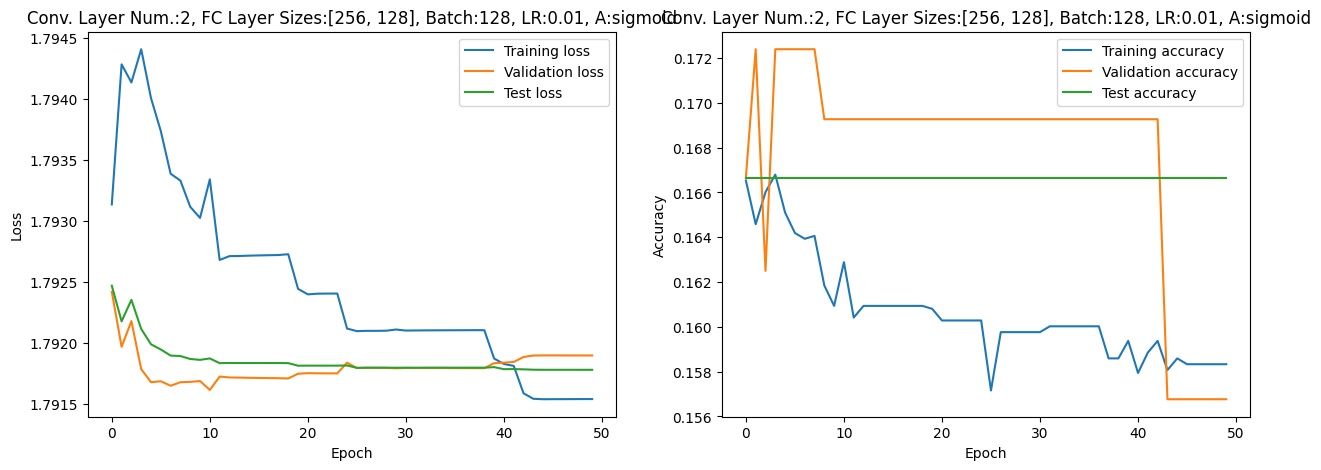


EXPERIMENT for CNN: 4
-------------
Conv. Layer Sizes:2, FC Layer Sizes:[256, 128], LR:0.01, A:relu


Epoch 10/50:
Train Loss:	1.7916	Train Accuracy:	16.91%
Val. Loss:	1.7920	Val. Accuracy:	15.68%
Test Loss:	1.7918	Test Accuracy:	16.67%

Epoch 20/50:
Train Loss:	1.7916	Train Accuracy:	16.91%
Val. Loss:	1.7920	Val. Accuracy:	15.68%
Test Loss:	1.7918	Test Accuracy:	16.67%

Epoch 30/50:
Train Loss:	1.7916	Train Accuracy:	16.91%
Val. Loss:	1.7920	Val. Accuracy:	15.68%
Test Loss:	1.7918	Test Accuracy:	16.67%

Epoch 40/50:
Train Loss:	1.7916	Train Accuracy:	16.91%
Val. Loss:	1.7920	Val. Accuracy:	15.68%
Test Loss:	1.7918	Test Accuracy:	16.67%

Epoch 50/50:
Train Loss:	1.7916	Train Accuracy:	16.91%
Val. Loss:	1.7920	Val. Accuracy:	15.68%
Test Loss:	1.7918	Test Accuracy:	16.67%


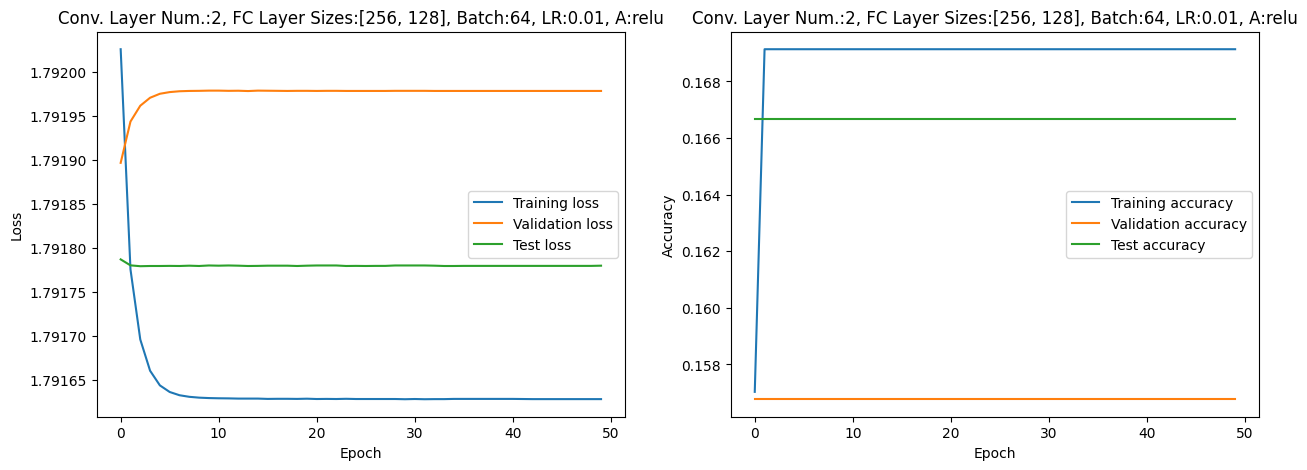


EXPERIMENT for CNN: 5
-------------
Conv. Layer Sizes:2, FC Layer Sizes:[256, 128], LR:0.001, A:sigmoid


Epoch 10/50:
Train Loss:	1.7924	Train Accuracy:	16.03%
Val. Loss:	1.7918	Val. Accuracy:	16.93%
Test Loss:	1.7918	Test Accuracy:	16.67%

Epoch 20/50:
Train Loss:	1.7673	Train Accuracy:	21.39%
Val. Loss:	1.7726	Val. Accuracy:	21.82%
Test Loss:	1.7738	Test Accuracy:	22.17%

Epoch 30/50:
Train Loss:	1.7113	Train Accuracy:	30.59%
Val. Loss:	1.7299	Val. Accuracy:	28.70%
Test Loss:	1.7277	Test Accuracy:	29.29%

Epoch 40/50:
Train Loss:	1.6875	Train Accuracy:	33.42%
Val. Loss:	1.7195	Val. Accuracy:	29.48%
Test Loss:	1.7195	Test Accuracy:	29.58%

Epoch 50/50:
Train Loss:	1.6851	Train Accuracy:	36.30%
Val. Loss:	1.7087	Val. Accuracy:	30.94%
Test Loss:	1.7090	Test Accuracy:	31.29%


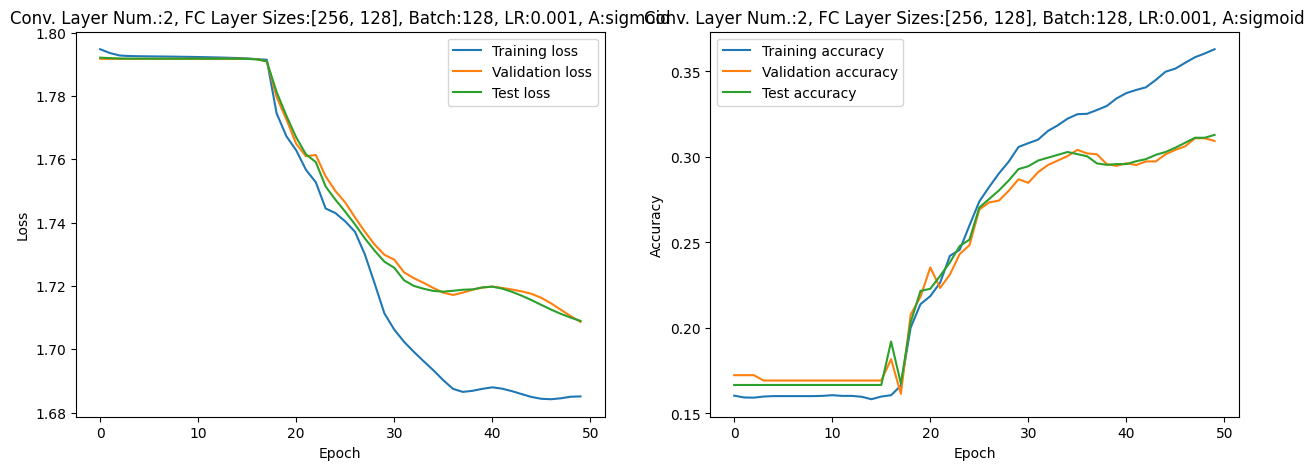


EXPERIMENT for CNN: 6
-------------
Conv. Layer Sizes:2, FC Layer Sizes:[256, 128], LR:0.001, A:relu


Epoch 10/50:
Train Loss:	1.7177	Train Accuracy:	32.17%
Val. Loss:	1.7251	Val. Accuracy:	28.59%
Test Loss:	1.7293	Test Accuracy:	29.00%

Epoch 20/50:
Train Loss:	1.6747	Train Accuracy:	36.71%
Val. Loss:	1.7180	Val. Accuracy:	29.53%
Test Loss:	1.7115	Test Accuracy:	30.96%

Epoch 30/50:
Train Loss:	1.5926	Train Accuracy:	41.94%
Val. Loss:	1.7045	Val. Accuracy:	31.72%
Test Loss:	1.6980	Test Accuracy:	31.92%

Epoch 40/50:
Train Loss:	1.5749	Train Accuracy:	46.15%
Val. Loss:	1.6736	Val. Accuracy:	35.16%
Test Loss:	1.6783	Test Accuracy:	34.71%

Epoch 50/50:
Train Loss:	1.5111	Train Accuracy:	52.71%
Val. Loss:	1.6797	Val. Accuracy:	35.00%
Test Loss:	1.6896	Test Accuracy:	33.79%


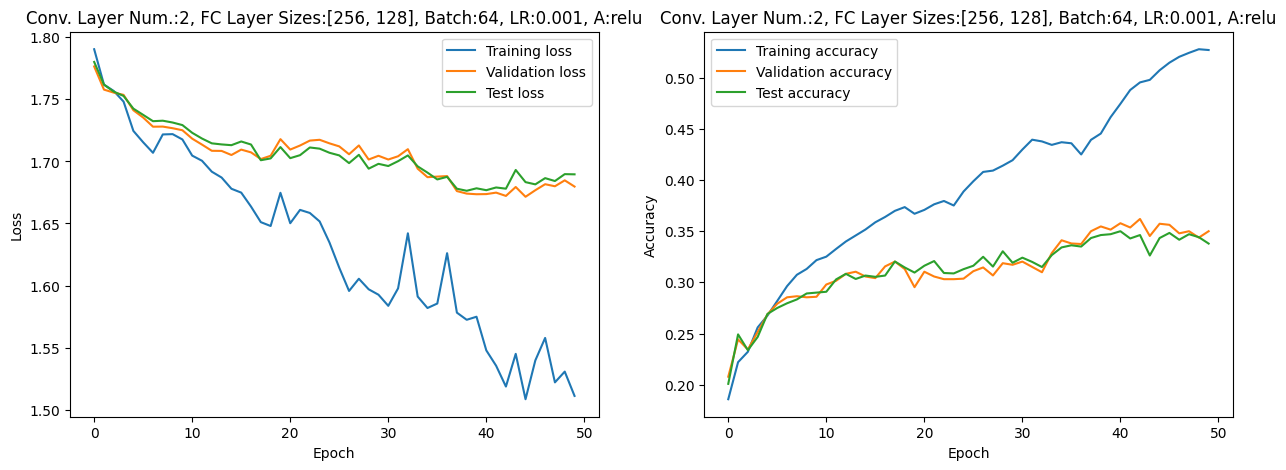


EXPERIMENT for CNN: 7
-------------
Conv. Layer Sizes:2, FC Layer Sizes:[128, 64], LR:0.01, A:sigmoid


Epoch 10/50:
Train Loss:	1.7911	Train Accuracy:	16.91%
Val. Loss:	1.7920	Val. Accuracy:	15.68%
Test Loss:	1.7918	Test Accuracy:	16.67%

Epoch 20/50:
Train Loss:	1.7911	Train Accuracy:	16.91%
Val. Loss:	1.7920	Val. Accuracy:	15.68%
Test Loss:	1.7918	Test Accuracy:	16.67%

Epoch 30/50:
Train Loss:	1.7911	Train Accuracy:	16.91%
Val. Loss:	1.7920	Val. Accuracy:	15.68%
Test Loss:	1.7918	Test Accuracy:	16.67%

Epoch 40/50:
Train Loss:	1.7911	Train Accuracy:	16.91%
Val. Loss:	1.7920	Val. Accuracy:	15.68%
Test Loss:	1.7918	Test Accuracy:	16.67%

Epoch 50/50:
Train Loss:	1.7911	Train Accuracy:	16.91%
Val. Loss:	1.7920	Val. Accuracy:	15.68%
Test Loss:	1.7918	Test Accuracy:	16.67%


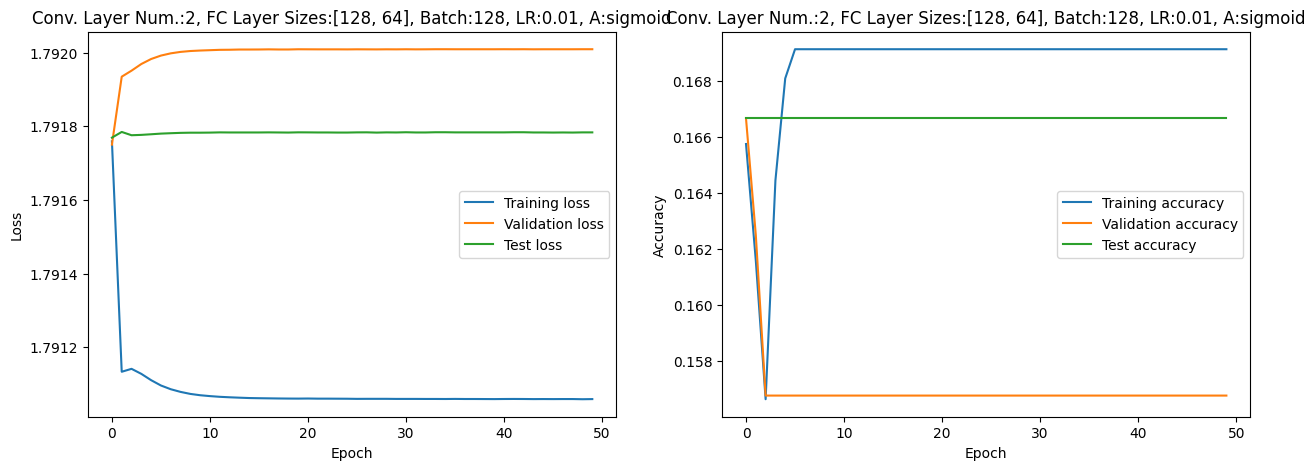


EXPERIMENT for CNN: 8
-------------
Conv. Layer Sizes:2, FC Layer Sizes:[128, 64], LR:0.001, A:relu


Epoch 10/50:
Train Loss:	1.7425	Train Accuracy:	28.70%
Val. Loss:	1.7461	Val. Accuracy:	26.04%
Test Loss:	1.7473	Test Accuracy:	26.38%

Epoch 20/50:
Train Loss:	1.7124	Train Accuracy:	32.29%
Val. Loss:	1.7396	Val. Accuracy:	27.03%
Test Loss:	1.7335	Test Accuracy:	28.58%

Epoch 30/50:
Train Loss:	1.6930	Train Accuracy:	35.38%
Val. Loss:	1.7342	Val. Accuracy:	27.40%
Test Loss:	1.7180	Test Accuracy:	30.54%

Epoch 40/50:
Train Loss:	1.7328	Train Accuracy:	37.23%
Val. Loss:	1.7269	Val. Accuracy:	29.48%
Test Loss:	1.7182	Test Accuracy:	30.25%

Epoch 50/50:
Train Loss:	1.6768	Train Accuracy:	40.73%
Val. Loss:	1.7355	Val. Accuracy:	28.80%
Test Loss:	1.7243	Test Accuracy:	29.62%


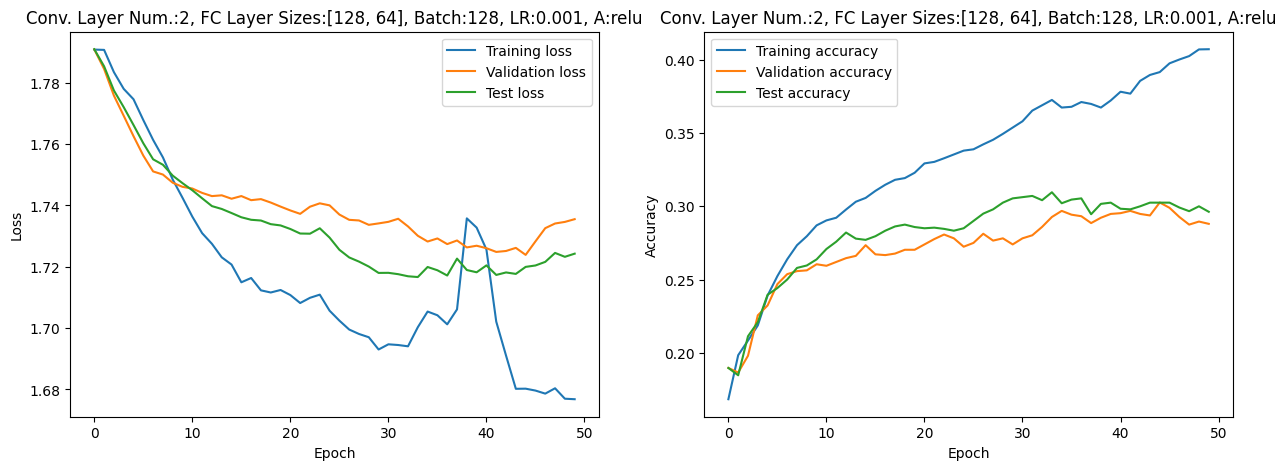


EXPERIMENT for CNN: 9
-------------
Conv. Layer Sizes:2, FC Layer Sizes:[1024], LR:0.01, A:sigmoid


Epoch 10/50:
Train Loss:	1.8873	Train Accuracy:	16.52%
Val. Loss:	1.8712	Val. Accuracy:	17.24%
Test Loss:	1.8769	Test Accuracy:	16.67%

Epoch 20/50:
Train Loss:	1.8873	Train Accuracy:	16.52%
Val. Loss:	1.8712	Val. Accuracy:	17.24%
Test Loss:	1.8769	Test Accuracy:	16.67%

Epoch 30/50:
Train Loss:	1.8873	Train Accuracy:	16.52%
Val. Loss:	1.8712	Val. Accuracy:	17.24%
Test Loss:	1.8769	Test Accuracy:	16.67%

Epoch 40/50:
Train Loss:	1.8873	Train Accuracy:	16.52%
Val. Loss:	1.8712	Val. Accuracy:	17.24%
Test Loss:	1.8769	Test Accuracy:	16.67%

Epoch 50/50:
Train Loss:	1.8873	Train Accuracy:	16.52%
Val. Loss:	1.8712	Val. Accuracy:	17.24%
Test Loss:	1.8769	Test Accuracy:	16.67%


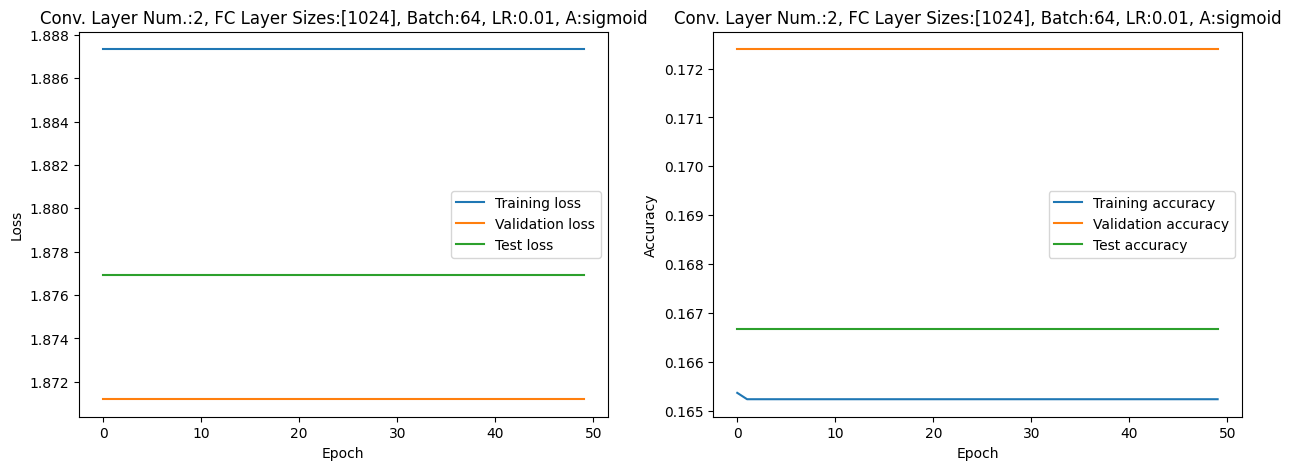


EXPERIMENT for CNN: 10
-------------
Conv. Layer Sizes:2, FC Layer Sizes:[1024], LR:0.001, A:relu


Epoch 10/50:
Train Loss:	1.6415	Train Accuracy:	36.11%
Val. Loss:	1.6936	Val. Accuracy:	33.02%
Test Loss:	1.7052	Test Accuracy:	30.79%

Epoch 20/50:
Train Loss:	1.5775	Train Accuracy:	45.96%
Val. Loss:	1.6694	Val. Accuracy:	35.05%
Test Loss:	1.6751	Test Accuracy:	34.79%

Epoch 30/50:
Train Loss:	1.4747	Train Accuracy:	53.53%
Val. Loss:	1.6665	Val. Accuracy:	35.89%
Test Loss:	1.6632	Test Accuracy:	36.38%

Epoch 40/50:
Train Loss:	1.4660	Train Accuracy:	61.12%
Val. Loss:	1.6687	Val. Accuracy:	35.52%
Test Loss:	1.6696	Test Accuracy:	35.58%

Epoch 50/50:
Train Loss:	1.3931	Train Accuracy:	70.39%
Val. Loss:	1.6714	Val. Accuracy:	36.25%
Test Loss:	1.6654	Test Accuracy:	36.46%


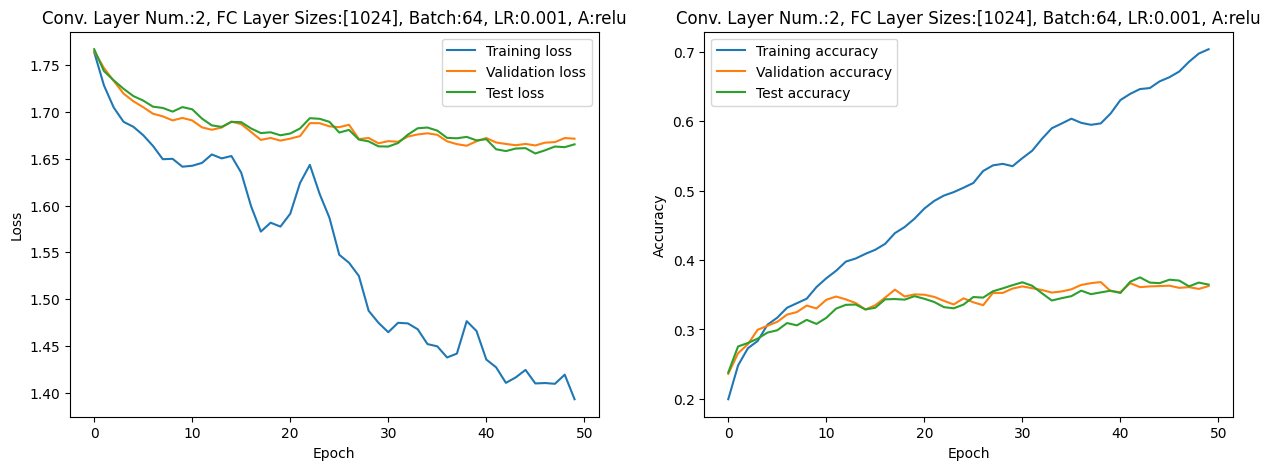


EXPERIMENT for CNN: 11
-------------
Conv. Layer Sizes:1, FC Layer Sizes:[512], LR:0.01, A:sigmoid


Epoch 10/50:
Train Loss:	1.8795	Train Accuracy:	16.60%
Val. Loss:	1.8743	Val. Accuracy:	16.93%
Test Loss:	1.8769	Test Accuracy:	16.67%

Epoch 20/50:
Train Loss:	1.8795	Train Accuracy:	16.60%
Val. Loss:	1.8743	Val. Accuracy:	16.93%
Test Loss:	1.8769	Test Accuracy:	16.67%

Epoch 30/50:
Train Loss:	1.8795	Train Accuracy:	16.60%
Val. Loss:	1.8743	Val. Accuracy:	16.93%
Test Loss:	1.8769	Test Accuracy:	16.67%

Epoch 40/50:
Train Loss:	1.8795	Train Accuracy:	16.60%
Val. Loss:	1.8743	Val. Accuracy:	16.93%
Test Loss:	1.8769	Test Accuracy:	16.67%

Epoch 50/50:
Train Loss:	1.9186	Train Accuracy:	16.52%
Val. Loss:	1.8712	Val. Accuracy:	17.24%
Test Loss:	1.8769	Test Accuracy:	16.67%


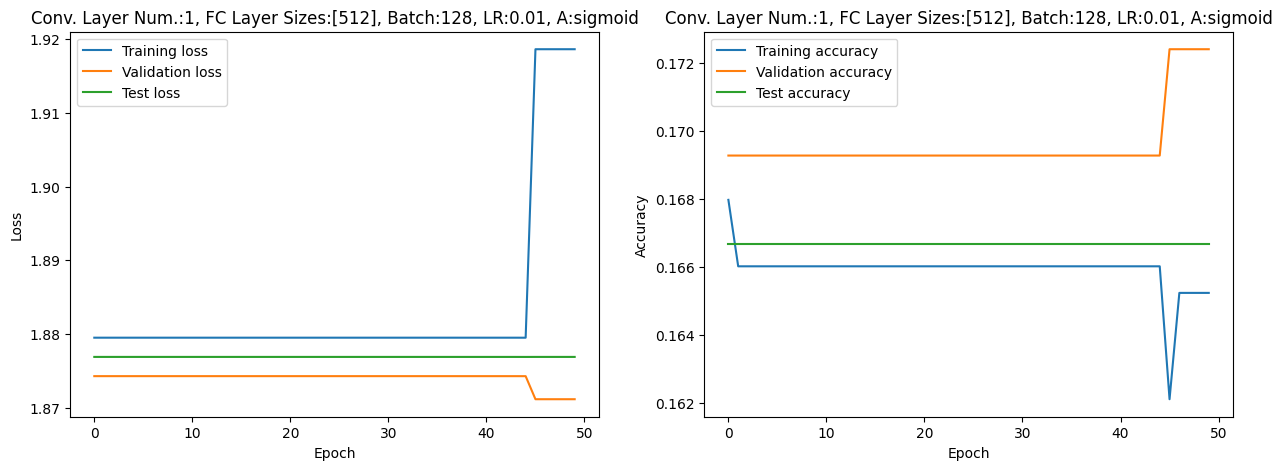


EXPERIMENT for CNN: 12
-------------
Conv. Layer Sizes:1, FC Layer Sizes:[512], LR:0.01, A:relu


Epoch 10/50:
Train Loss:	1.7916	Train Accuracy:	16.91%
Val. Loss:	1.7920	Val. Accuracy:	15.68%
Test Loss:	1.7918	Test Accuracy:	16.67%

Epoch 20/50:
Train Loss:	1.7916	Train Accuracy:	16.91%
Val. Loss:	1.7920	Val. Accuracy:	15.68%
Test Loss:	1.7918	Test Accuracy:	16.67%

Epoch 30/50:
Train Loss:	1.7916	Train Accuracy:	16.91%
Val. Loss:	1.7920	Val. Accuracy:	15.68%
Test Loss:	1.7918	Test Accuracy:	16.67%

Epoch 40/50:
Train Loss:	1.7916	Train Accuracy:	16.91%
Val. Loss:	1.7920	Val. Accuracy:	15.68%
Test Loss:	1.7918	Test Accuracy:	16.67%

Epoch 50/50:
Train Loss:	1.7916	Train Accuracy:	16.91%
Val. Loss:	1.7920	Val. Accuracy:	15.68%
Test Loss:	1.7918	Test Accuracy:	16.67%


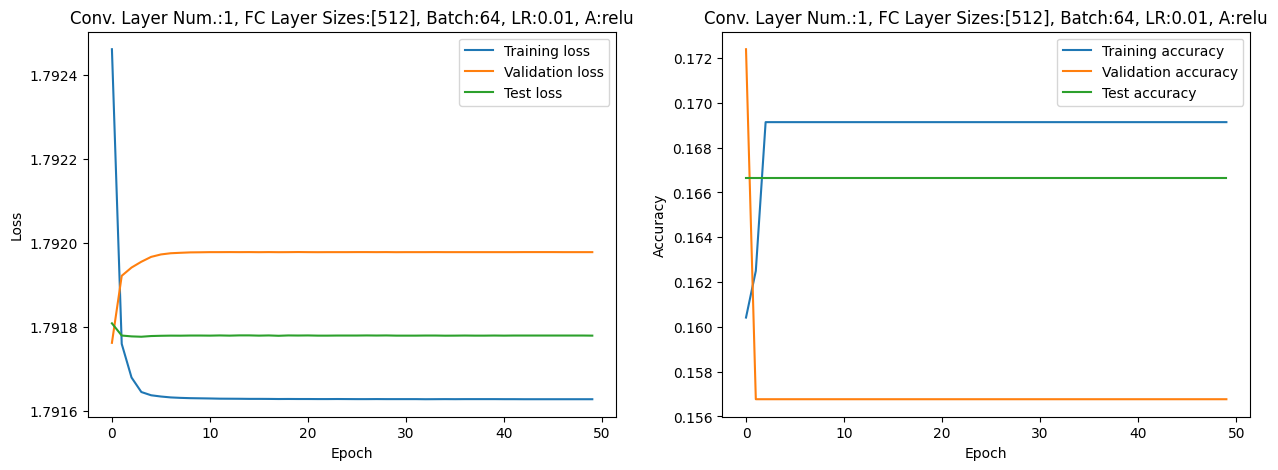


EXPERIMENT for CNN: 13
-------------
Conv. Layer Sizes:1, FC Layer Sizes:[512], LR:0.001, A:sigmoid


Epoch 10/50:
Train Loss:	1.7943	Train Accuracy:	16.86%
Val. Loss:	1.7922	Val. Accuracy:	16.25%
Test Loss:	1.7923	Test Accuracy:	16.67%

Epoch 20/50:
Train Loss:	1.7731	Train Accuracy:	20.48%
Val. Loss:	1.7733	Val. Accuracy:	21.56%
Test Loss:	1.7770	Test Accuracy:	20.50%

Epoch 30/50:
Train Loss:	1.7487	Train Accuracy:	22.54%
Val. Loss:	1.7617	Val. Accuracy:	21.72%
Test Loss:	1.7628	Test Accuracy:	22.96%

Epoch 40/50:
Train Loss:	1.7539	Train Accuracy:	25.23%
Val. Loss:	1.7542	Val. Accuracy:	24.48%
Test Loss:	1.7547	Test Accuracy:	25.37%

Epoch 50/50:
Train Loss:	1.7432	Train Accuracy:	27.47%
Val. Loss:	1.7425	Val. Accuracy:	27.45%
Test Loss:	1.7437	Test Accuracy:	27.25%


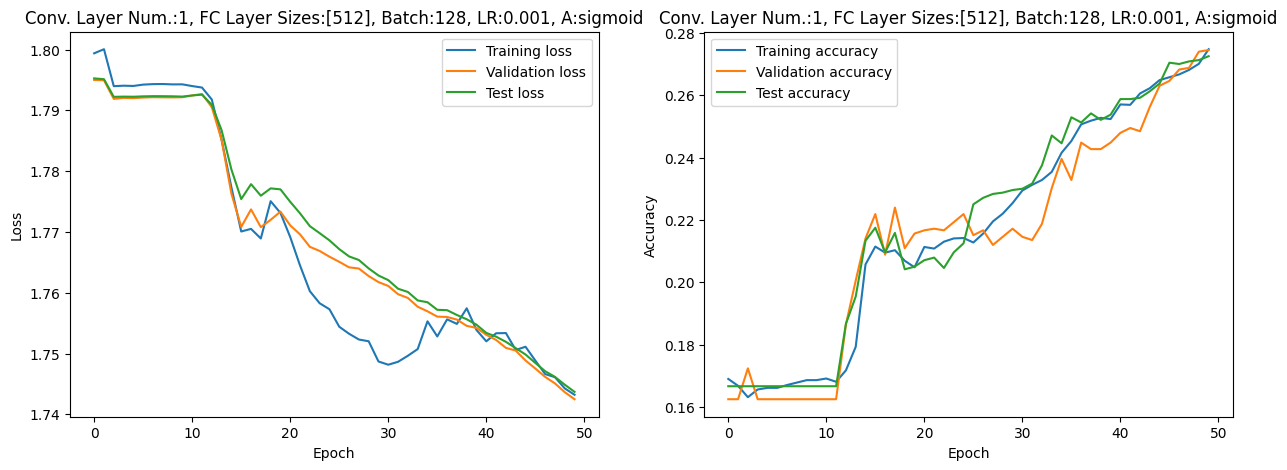


EXPERIMENT for CNN: 14
-------------
Conv. Layer Sizes:1, FC Layer Sizes:[512], LR:0.001, A:relu


Epoch 10/50:
Train Loss:	1.6707	Train Accuracy:	35.99%
Val. Loss:	1.6890	Val. Accuracy:	33.80%
Test Loss:	1.7000	Test Accuracy:	31.71%

Epoch 20/50:
Train Loss:	1.5807	Train Accuracy:	45.29%
Val. Loss:	1.6668	Val. Accuracy:	36.61%
Test Loss:	1.6719	Test Accuracy:	34.96%

Epoch 30/50:
Train Loss:	1.5532	Train Accuracy:	50.52%
Val. Loss:	1.6685	Val. Accuracy:	36.04%
Test Loss:	1.6721	Test Accuracy:	35.58%

Epoch 40/50:
Train Loss:	1.5162	Train Accuracy:	54.49%
Val. Loss:	1.6520	Val. Accuracy:	37.40%
Test Loss:	1.6603	Test Accuracy:	35.88%

Epoch 50/50:
Train Loss:	1.4705	Train Accuracy:	61.05%
Val. Loss:	1.6372	Val. Accuracy:	39.27%
Test Loss:	1.6328	Test Accuracy:	38.88%


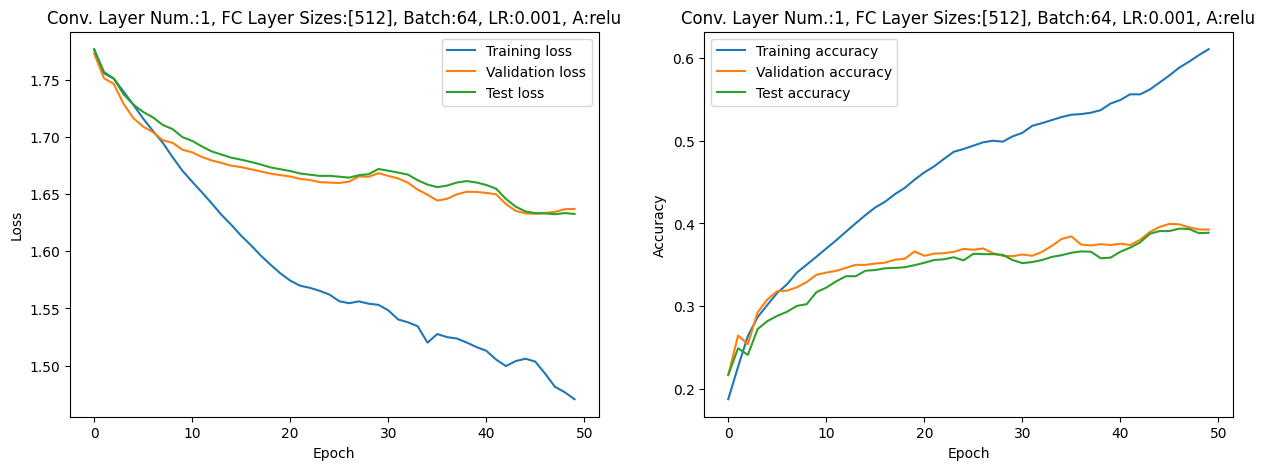


EXPERIMENT for CNN: 15
-------------
Conv. Layer Sizes:1, FC Layer Sizes:[256], LR:0.01, A:sigmoid


Epoch 10/50:
Train Loss:	1.8061	Train Accuracy:	17.67%
Val. Loss:	1.8140	Val. Accuracy:	16.93%
Test Loss:	1.8140	Test Accuracy:	16.67%

Epoch 20/50:
Train Loss:	1.8365	Train Accuracy:	16.98%
Val. Loss:	1.8192	Val. Accuracy:	16.93%
Test Loss:	1.8230	Test Accuracy:	16.67%

Epoch 30/50:
Train Loss:	1.8331	Train Accuracy:	17.10%
Val. Loss:	1.8180	Val. Accuracy:	16.93%
Test Loss:	1.8219	Test Accuracy:	16.67%

Epoch 40/50:
Train Loss:	1.8322	Train Accuracy:	17.04%
Val. Loss:	1.8174	Val. Accuracy:	16.93%
Test Loss:	1.8214	Test Accuracy:	16.67%

Epoch 50/50:
Train Loss:	1.8323	Train Accuracy:	17.04%
Val. Loss:	1.8174	Val. Accuracy:	16.93%
Test Loss:	1.8215	Test Accuracy:	16.67%


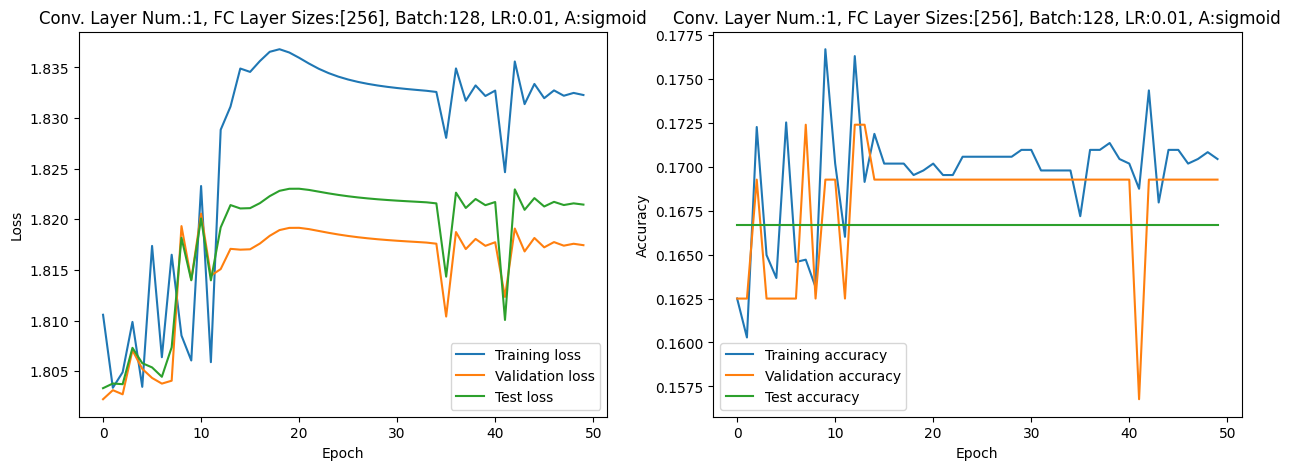


EXPERIMENT for CNN: 16
-------------
Conv. Layer Sizes:1, FC Layer Sizes:[256], LR:0.001, A:relu


Epoch 10/50:
Train Loss:	1.7018	Train Accuracy:	34.71%
Val. Loss:	1.6974	Val. Accuracy:	33.39%
Test Loss:	1.7078	Test Accuracy:	30.71%

Epoch 20/50:
Train Loss:	1.6364	Train Accuracy:	41.60%
Val. Loss:	1.6662	Val. Accuracy:	36.09%
Test Loss:	1.6727	Test Accuracy:	35.29%

Epoch 30/50:
Train Loss:	1.5963	Train Accuracy:	47.67%
Val. Loss:	1.6586	Val. Accuracy:	37.08%
Test Loss:	1.6609	Test Accuracy:	35.33%

Epoch 40/50:
Train Loss:	1.5779	Train Accuracy:	52.67%
Val. Loss:	1.6463	Val. Accuracy:	37.76%
Test Loss:	1.6502	Test Accuracy:	37.04%

Epoch 50/50:
Train Loss:	1.5444	Train Accuracy:	53.03%
Val. Loss:	1.6412	Val. Accuracy:	38.75%
Test Loss:	1.6445	Test Accuracy:	37.62%


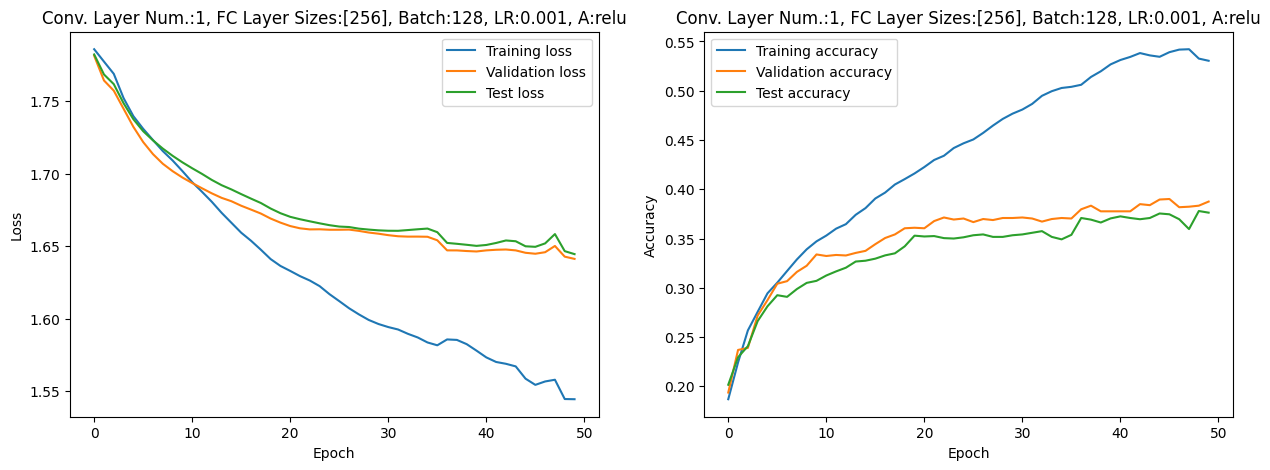

In [27]:
cnn_results = experiment_CNN(X_train_images, train_y, X_val_images, val_y, test_images, test_y)

cnn_results_df = pd.DataFrame(cnn_results)

In [30]:
cnn_results_df.set_index("Experiments", inplace=True)

cnn_results_df

Input Size Activation  Conv. Layer Num Hidden Layer Size  \
Experiments                                                            
1                32x32    sigmoid                2        [512, 256]   
2                32x32       relu                2        [512, 256]   
3                32x32    sigmoid                2        [256, 128]   
4                32x32       relu                2        [256, 128]   
5                32x32    sigmoid                2        [256, 128]   
6                32x32       relu                2        [256, 128]   
7                32x32    sigmoid                2         [128, 64]   
8                32x32       relu                2         [128, 64]   
9                32x32    sigmoid                1            [1024]   
10               32x32       relu                1            [1024]   
11               32x32    sigmoid                1             [512]   
12               32x32       relu                1             [512]   
13               32x32    sigmoid                1             [512]   
14               32x32       relu                1             [512]   
15               32x32    sigmoid                1             [256]   
16               32x32       relu                1             [256]   

             Learning Rate  Batch Size  Epoch  Accuracy  
Experiments                                              
1                    0.010          64     50  0.166667  
2                    0.001          64     50  0.350000  
3                    0.010         128     50  0.166667  
4                    0.010          64     50  0.166667  
5                    0.001         128     50  0.312917  
6                    0.001          64     50  0.337917  
7                    0.010         128     50  0.166667  
8                    0.001         128     50  0.296250  
9                    0.010          64     50  0.166667  
10                   0.001          64     50  0.364583  
11                   0.010         128     50  0.166667  
12                   0.010          64     50  0.166667  
13                   0.001         128     50  0.272500  
14                   0.001          64     50  0.388750  
15                   0.010         128     50  0.166667  
16                   0.001         128     50  0.376250

# Analysis of CNN Results:

Firstly, the model is underfitted in data and got some weird results in some models, i've tried many different ways and spent many hours to resolve it but could not do it. So it is not possible to comment and analyse these results in such a good way but i'll try it with what i have. 

***Activation Function:***
There you can see sigmoid function's losses and accuracy values generally goes constant at 16.67% in first 50 epochs, they may be changed after but we're not able to see it since i've worked with 50 epochs. But ReLu provided decent accuracies around 30-35%. We can say that ReLU is better choice to work on this data with this model. 

***Learning Rate:***
When we look at the results, we can clearly see the model's underfitted with data in some experiments. So the model provides better accuracy in lower learning rate value 0.001. It 
makes the model undergoes a slower learning process and allows finer tuning of the weights.

***Batch Size:***
The smaller batch size 64, provides model to give better accuracies usually in these results, it introduces more variability in training process and preventing the model from memorizing unnecessary spesific examples and often leads to faster convergence and improves the model's performance.

***Layer Sizes:***
In these results, the models that got free from 16.67% band in test accuracy, reaches better accuracies when layer numbers are 1. It should be in reversed way since accuracy should increase when complexity has increased in model but like i've mentioned above, these results are not good. And accuracies get better when we increased the number of units in hidden layers.

